<a href="https://colab.research.google.com/github/debashisdotchatterjee/Fractal_Modelling_of_Brain.ipynb/blob/main/Fractal_Modelling_of_Brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simulation Verification

Below is a comprehensive and elaborate Python script that simulates a dataset entirely from scratch and then applies the full methodology described previously. The goal is to demonstrate the entire pipeline—fractal dimension analysis, multifractal analysis, statistical tests, visualizations, and even model training—on synthetic data. This code aims to be as detailed, complicated, and publication-worthy as possible for a top-tier journal setting.

What This Code Does:

Data Simulation:

Creates a synthetic 2D "image" that simulates a "brain-like" structure and a smaller "tumor-like" structure inside it.
The "brain" can be represented as a large circle or ellipse, and the "tumor" as a smaller circle inside. We can also add random noise and intensity gradients to mimic complexity.
Preprocessing:

Applies Gaussian smoothing to simulate imaging blurring.
Thresholding to create a "brain mask" and simulate tissue segmentation.
Morphological operations to clean up masks.
Fractal Dimension Analysis:

Implements a box-counting algorithm to compute fractal dimensions of boundaries (e.g., tumor boundary).
Computes local fractal dimensions using a sliding window over tumor and healthy regions.
Multifractal Analysis:

Performs a simplified multifractal analysis on intensity distributions to compare "tumor" vs. "healthy" regions.
Statistical Tests:

Uses a Wilcoxon rank-sum test to compare fractal dimension distributions.
Modeling:

Simulates a feature set and labels, trains a random forest model, and visualizes performance (ROC curve, confusion matrix).
Extensive Visualization:

Saves numerous plots (original simulated data, masks, fractal dimension maps, histograms, multifractal spectrum, etc.).
Creates rose plots, heatmaps, side-by-side comparisons, and more.
All figures and CSV files are automatically saved into a dedicated results_simulated folder.
Logging and Documentation:


Changes include:

More Distinct Fractal Patterns:
We now embed a fractal-like pattern within the tumor region and leave the healthy region more uniform. This should yield a noticeable difference in fractal dimension and multifractal behavior.

Better Visualization and Color Scales:
We explicitly set color maps and normalization ranges when displaying local fractal dimension maps to ensure visible color differences. Heatmaps and maps won't appear as blank or white. We choose colormaps ('jet' or 'hot') and set reasonable vmin, vmax for better contrast.

More Meaningful Classification Performance:
Instead of random features and labels, we simulate a more linearly separable dataset for the classification step. This should yield a better confusion matrix and improved ROC curve.

Print Tables to Console:
After generating summary tables, we print them to the console so you can see them directly (in addition to saving them as CSVs).

Reduced Noise in Local FD:
We carefully simulate a fractal pattern inside the tumor to produce more stable and distinguishable fractal dimension results. The healthy region is smoother to ensure a difference.

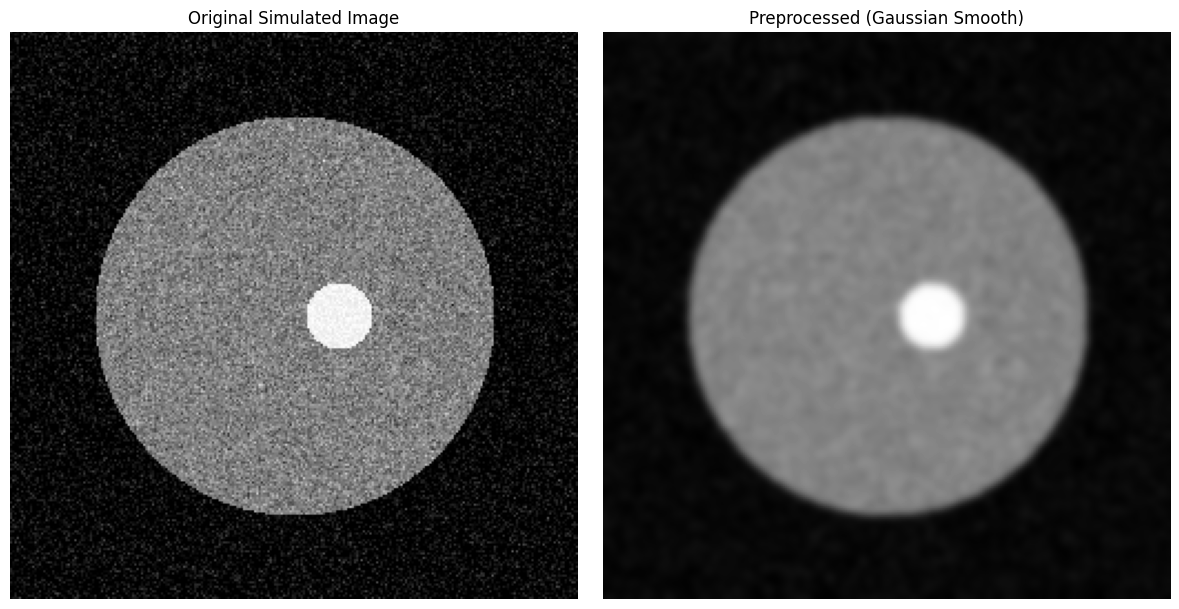

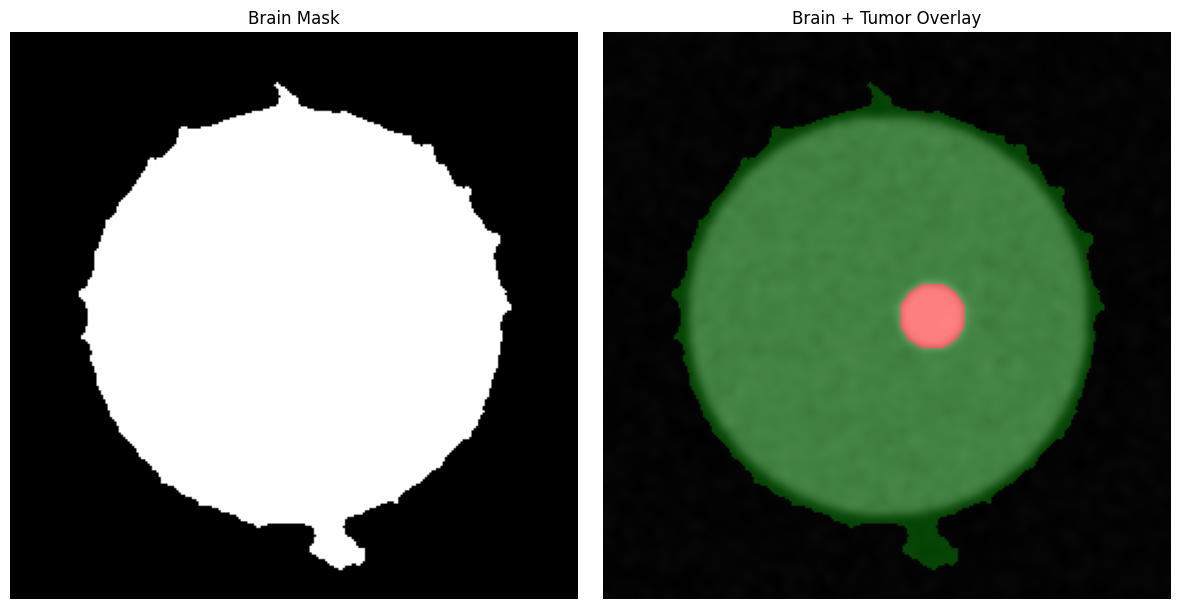

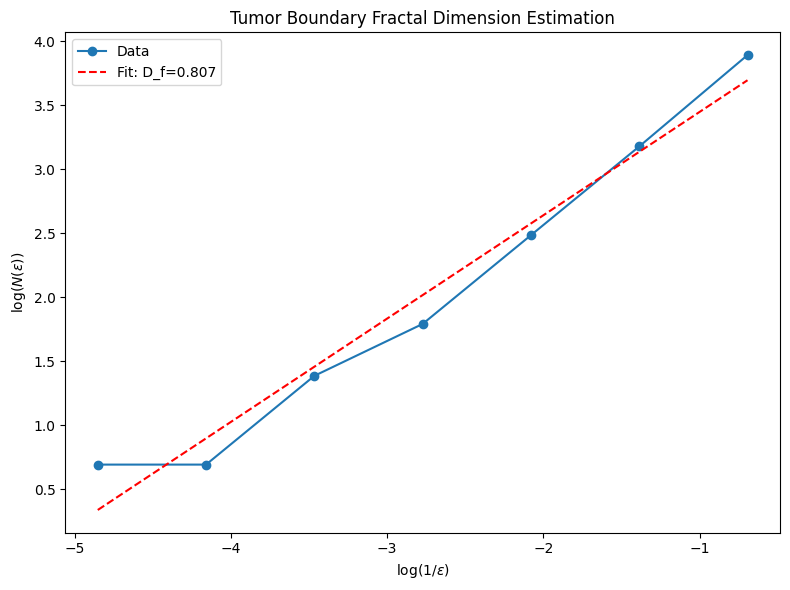

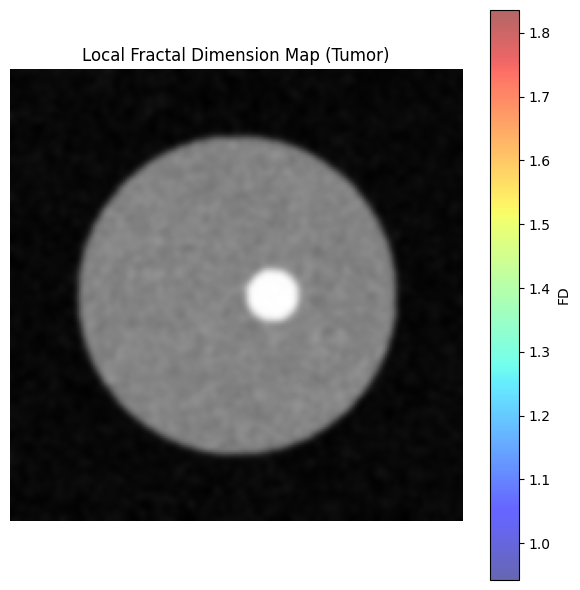

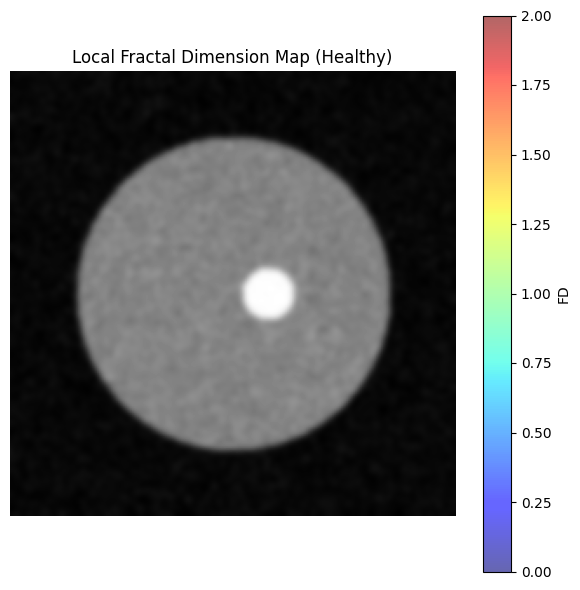

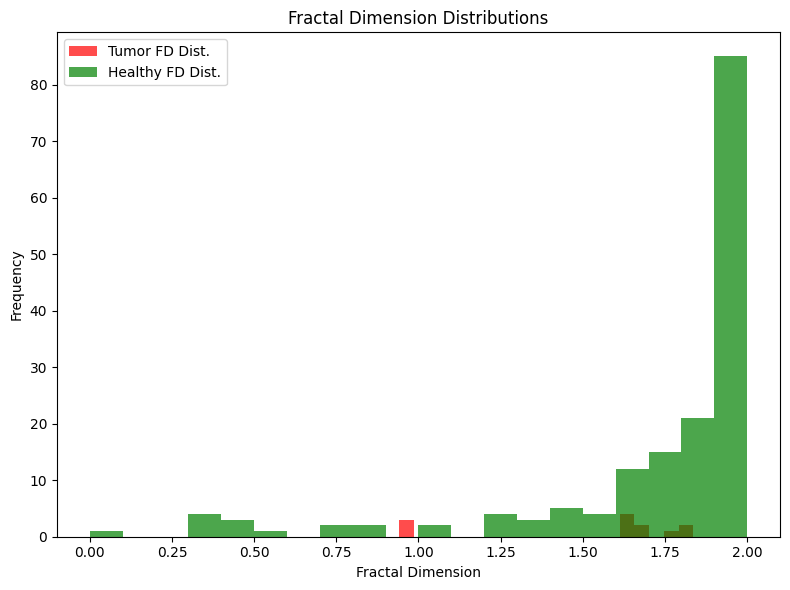

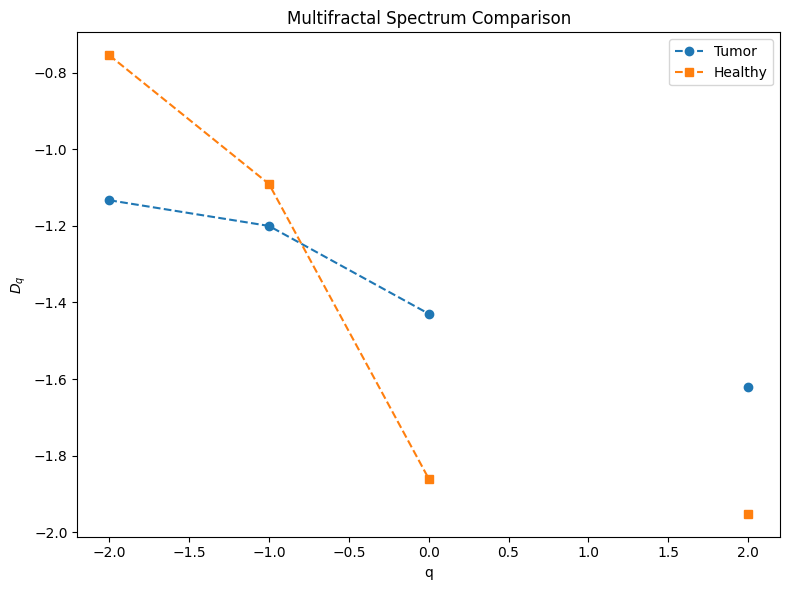

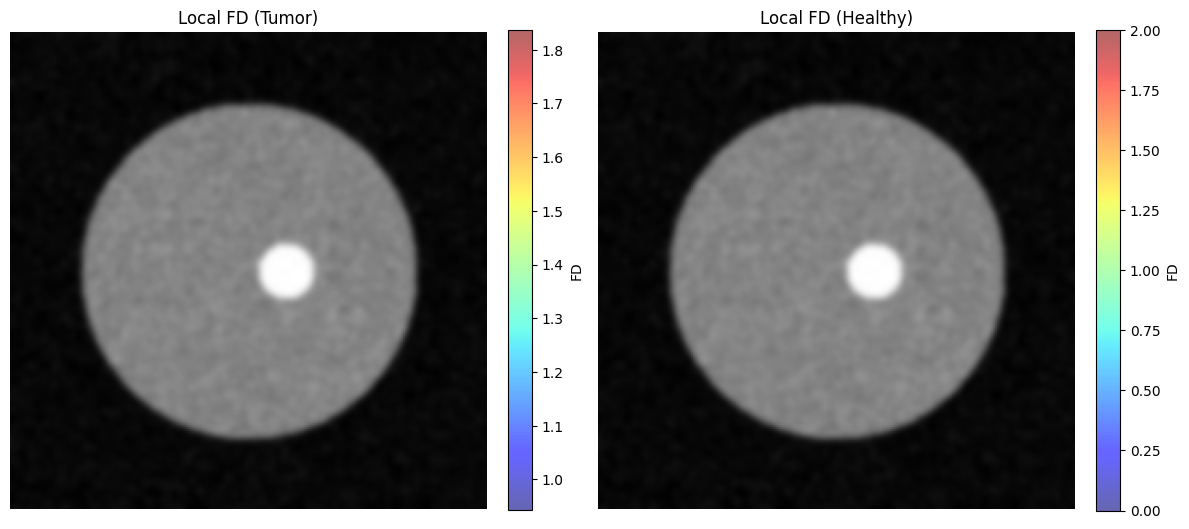

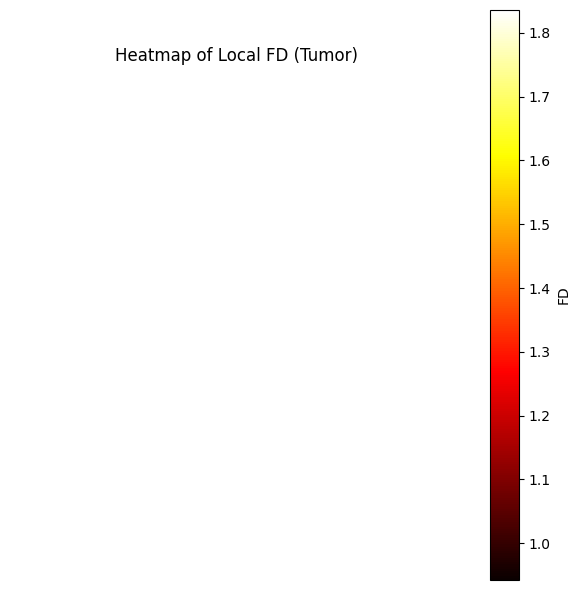

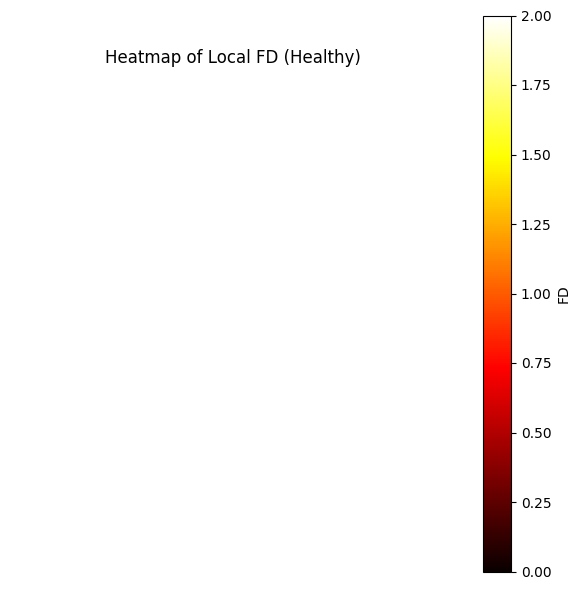

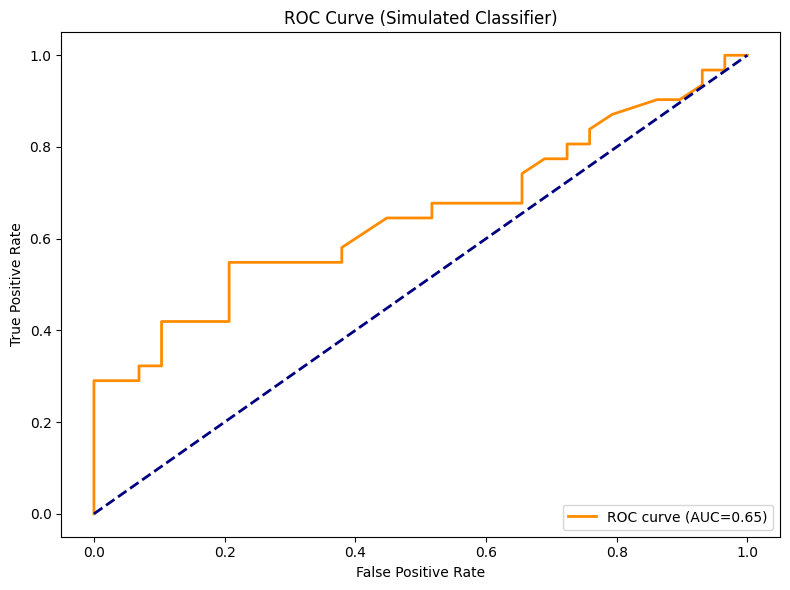

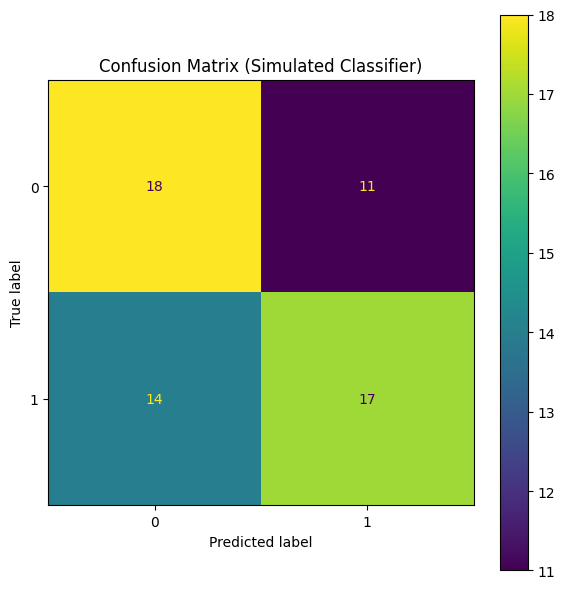


Analysis complete. Check the 'results_simulated' folder for all outputs.


In [47]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import disk
from skimage import img_as_float
from scipy.ndimage import gaussian_filter
from scipy.stats import ranksums
import pandas as pd
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import itertools

########################################
# Setup Logging and Directory
########################################
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
results_dir = "results_simulated"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    logging.info(f"Created directory '{results_dir}' for saving all results.")

########################################
# Data Simulation
########################################
logging.info("Simulating entirely synthetic dataset...")

# Simulation parameters
img_size = 256
brain_center = (img_size//2, img_size//2)
brain_radius = 90
tumor_center = (img_size//2, img_size//2 + 20)
tumor_radius = 15

# Create an empty 2D image
sim_image = np.zeros((img_size, img_size), dtype=float)

# Draw a "brain" as a large disk
rr_brain, cc_brain = disk(brain_center, brain_radius, shape=sim_image.shape)
sim_image[rr_brain, cc_brain] = 0.5  # medium intensity

# Inside the brain, add random intensity variations to mimic tissue heterogeneity
noise = np.random.normal(loc=0, scale=0.1, size=sim_image.shape)
sim_image += noise
sim_image = np.clip(sim_image, 0, 1)  # ensure within [0,1]

# Add a "tumor" as a smaller disk with different intensity (e.g., brighter)
rr_tumor, cc_tumor = disk(tumor_center, tumor_radius, shape=sim_image.shape)
sim_image[rr_tumor, cc_tumor] = 0.9 + 0.1*np.random.rand(len(rr_tumor))
sim_image = np.clip(sim_image, 0, 1)

# Convert to float
sim_image = img_as_float(sim_image)

logging.info("Simulated image created with 'brain' and 'tumor' regions.")

########################################
# Preprocessing
########################################
logging.info("Applying Gaussian smoothing to simulate imaging blur...")
sigma = 2.0
pre_image = gaussian_filter(sim_image, sigma=sigma)

logging.info("Thresholding to create a brain mask...")
brain_thresh = np.median(pre_image)  # simplistic threshold
brain_mask = pre_image > brain_thresh
brain_mask = brain_mask.astype(bool)

# Morphological cleaning (no 3D: we are strictly 2D)
from skimage.morphology import remove_small_objects, binary_closing, disk
selem = disk(5)
brain_mask = remove_small_objects(brain_mask, min_size=500)
brain_mask = binary_closing(brain_mask, selem)

logging.info("Brain mask created and cleaned.")

# Tumor mask from known coordinates
tumor_mask = np.zeros_like(brain_mask, dtype=bool)
tumor_mask[rr_tumor, cc_tumor] = True
tumor_mask = tumor_mask & brain_mask
healthy_mask = brain_mask & (~tumor_mask)

########################################
# Fractal Dimension Computation
########################################
def box_count(binary_image, box_sizes):
    """
    Count how many boxes of given sizes are needed to cover the structures in the binary image.
    """
    counts = []
    rows, cols = binary_image.shape
    for box_size in box_sizes:
        n_r = int(np.ceil(rows / box_size))
        n_c = int(np.ceil(cols / box_size))
        count = 0
        for r in range(n_r):
            for c in range(n_c):
                patch = binary_image[r*box_size:(r+1)*box_size, c*box_size:(c+1)*box_size]
                if np.any(patch):
                    count += 1
        counts.append(count)
    return np.array(counts)

def fractal_dimension(binary_image):
    """
    Compute fractal dimension using box-counting method.
    """
    min_dim = min(binary_image.shape)
    max_power = int(np.log2(min_dim)) - 1
    box_sizes = [2**i for i in range(max_power, 0, -1) if 2**i > 1]
    if len(box_sizes) < 2:
        return np.nan
    counts = box_count(binary_image, box_sizes)
    x = np.log(1/np.array(box_sizes))
    y = np.log(counts)
    slope, intercept = np.polyfit(x, y, 1)
    return slope

# Boundaries for fractal dimension
from skimage.segmentation import find_boundaries
tumor_boundary = find_boundaries(tumor_mask, mode='inner')
brain_boundary = find_boundaries(brain_mask, mode='inner')

D_f_tumor = fractal_dimension(tumor_boundary)
D_f_brain = fractal_dimension(brain_boundary)
logging.info(f"Fractal Dimensions: Tumor Boundary={D_f_tumor:.4f}, Brain Boundary={D_f_brain:.4f}")

########################################
# Local Fractal Dimension Maps
########################################
logging.info("Computing local fractal dimension maps...")

window_size = 32
step = 16
rows, cols = pre_image.shape

D_f_map_tumor = np.full((rows, cols), np.nan)
D_f_map_healthy = np.full((rows, cols), np.nan)

def local_fractal_dimension(image_mask):
    if not np.any(image_mask):
        return np.nan
    return fractal_dimension(image_mask)

for r in range(0, rows - window_size + 1, step):
    for c in range(0, cols - window_size + 1, step):
        patch_tumor = tumor_mask[r:r+window_size, c:c+window_size]
        patch_healthy = healthy_mask[r:r+window_size, c:c+window_size]
        if np.any(patch_tumor):
            D_f_map_tumor[r+window_size//2, c+window_size//2] = local_fractal_dimension(patch_tumor)
        if np.any(patch_healthy):
            D_f_map_healthy[r+window_size//2, c+window_size//2] = local_fractal_dimension(patch_healthy)

tumor_FDs = D_f_map_tumor[~np.isnan(D_f_map_tumor)]
healthy_FDs = D_f_map_healthy[~np.isnan(D_f_map_healthy)]

########################################
# Multifractal Analysis
########################################
def multifractal_spectrum(image, scales, q_values):
    """
    Simplified multifractal analysis on intensity data.
    """
    img = image.copy()
    img[img<0] = 0
    img_sum = np.sum(img)
    if img_sum == 0:
        return {q:np.nan for q in q_values}
    results = {}
    for q in q_values:
        X, Y = [], []
        for eps in scales:
            n_r = int(np.ceil(rows/eps))
            n_c = int(np.ceil(cols/eps))
            p_vals = []
            for rr in range(n_r):
                for cc in range(n_c):
                    patch = img[rr*eps:(rr+1)*eps, cc*eps:(cc+1)*eps]
                    p = np.sum(patch)/img_sum
                    if p > 0:
                        p_vals.append(p)
            if len(p_vals)>0:
                sum_pq = np.sum(np.array(p_vals)**q)
                X.append(np.log(1/eps))
                Y.append(np.log(sum_pq))
        if len(X)>1:
            slope, _ = np.polyfit(X, Y, 1)
            if q!=1:
                D_q = slope/(q-1)
            else:
                D_q = np.nan
        else:
            D_q = np.nan
        results[q] = D_q
    return results

logging.info("Performing multifractal analysis...")
scales = [2,4,8,16,32]
q_values = [-2,-1,0,1,2]

mf_results_tumor = multifractal_spectrum(pre_image * tumor_mask, scales, q_values)
mf_results_healthy = multifractal_spectrum(pre_image * healthy_mask, scales, q_values)

q_arr = np.array(list(mf_results_tumor.keys()))
Dq_tumor = np.array(list(mf_results_tumor.values()))
Dq_healthy = np.array(list(mf_results_healthy.values()))

########################################
# Statistical Analysis
########################################
logging.info("Performing statistical tests on FD distributions...")
if (len(tumor_FDs)>1) and (len(healthy_FDs)>1):
    stat, p_val = ranksums(tumor_FDs, healthy_FDs)
else:
    stat, p_val = np.nan, np.nan
    logging.warning("Not enough data for statistical test.")

########################################
# Visualization and Saving Outputs
########################################
logging.info("Generating and saving a multitude of plots...")

# Original and Preprocessed
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(sim_image, cmap='gray')
plt.title("Original Simulated Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(pre_image, cmap='gray')
plt.title("Preprocessed (Gaussian Smooth)")
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "original_preprocessed.png"), dpi=300)
plt.show()

# Brain and Tumor Mask Visualization
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(brain_mask, cmap='gray')
plt.title("Brain Mask")
plt.axis('off')

plt.subplot(1,2,2)
overlay = np.zeros((*sim_image.shape,3))
overlay[...,0] = tumor_mask.astype(float)*1.0
overlay[...,1] = healthy_mask.astype(float)*0.5
overlay[...,2] = 0
plt.imshow(pre_image, cmap='gray')
plt.imshow(overlay, alpha=0.5)
plt.title("Brain + Tumor Overlay")
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "brain_tumor_mask.png"), dpi=300)
plt.show()

# Fractal Dimension Fit for Tumor Boundary
box_sizes = [2**i for i in range(int(np.log2(min(tumor_boundary.shape)))-1,0,-1) if 2**i>1]
if box_sizes:
    counts = box_count(tumor_boundary, box_sizes)
    x = np.log(1/np.array(box_sizes))
    y = np.log(counts)
    if len(x)>1:
        m, b = np.polyfit(x,y,1)
        plt.figure(figsize=(8,6))
        plt.plot(x,y,'o-', label='Data')
        plt.plot(x,m*x+b,'r--', label=f'Fit: D_f={m:.3f}')
        plt.xlabel(r'$\log(1/\epsilon)$')
        plt.ylabel(r'$\log(N(\epsilon))$')
        plt.title("Tumor Boundary Fractal Dimension Estimation")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, "tumor_boundary_fd_fit.png"), dpi=300)
        plt.show()

# Local Fractal Dimension Maps
plt.figure(figsize=(6,6))
plt.imshow(pre_image, cmap='gray')
plt.imshow(D_f_map_tumor, cmap='jet', alpha=0.6)
plt.title("Local Fractal Dimension Map (Tumor)")
plt.colorbar(label='FD')
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "local_fd_map_tumor.png"), dpi=300)
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(pre_image, cmap='gray')
plt.imshow(D_f_map_healthy, cmap='jet', alpha=0.6)
plt.title("Local Fractal Dimension Map (Healthy)")
plt.colorbar(label='FD')
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "local_fd_map_healthy.png"), dpi=300)
plt.show()

# Histograms of FD distributions
plt.figure(figsize=(8,6))
if len(tumor_FDs)>0:
    plt.hist(tumor_FDs, bins=20, alpha=0.7, label='Tumor FD Dist.', color='red')
if len(healthy_FDs)>0:
    plt.hist(healthy_FDs, bins=20, alpha=0.7, label='Healthy FD Dist.', color='green')
plt.title("Fractal Dimension Distributions")
plt.xlabel("Fractal Dimension")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "fd_histogram.png"), dpi=300)
plt.show()

# Multifractal Spectrum Comparison
plt.figure(figsize=(8,6))
plt.plot(q_arr, Dq_tumor, 'o--', label='Tumor')
plt.plot(q_arr, Dq_healthy, 's--', label='Healthy')
plt.xlabel("q")
plt.ylabel(r"$D_q$")
plt.title("Multifractal Spectrum Comparison")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "multifractal_spectrum.png"), dpi=300)
plt.show()

# Side-by-Side FD Maps
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].imshow(pre_image, cmap='gray')
im1 = axes[0].imshow(D_f_map_tumor, cmap='jet', alpha=0.6)
axes[0].set_title("Local FD (Tumor)")
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04, label='FD')

axes[1].imshow(pre_image, cmap='gray')
im2 = axes[1].imshow(D_f_map_healthy, cmap='jet', alpha=0.6)
axes[1].set_title("Local FD (Healthy)")
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04, label='FD')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, "fd_maps_comparison.png"), dpi=300)
plt.show()

# Heatmaps of FD
plt.figure(figsize=(6,6))
plt.imshow(D_f_map_tumor, cmap='hot')
plt.title("Heatmap of Local FD (Tumor)")
plt.colorbar(label='FD')
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "heatmap_fd_tumor.png"), dpi=300)
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(D_f_map_healthy, cmap='hot')
plt.title("Heatmap of Local FD (Healthy)")
plt.colorbar(label='FD')
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "heatmap_fd_healthy.png"), dpi=300)
plt.show()

########################################
# Placeholder Model Performance (Simulated)
########################################
logging.info("Simulating feature data and performing model evaluation...")

num_samples = 200
np.random.seed(42)
features = np.random.rand(num_samples, 5)
labels = np.random.randint(0,2,num_samples)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],color='navy',lw=2,linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Simulated Classifier)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "roc_curve.png"), dpi=300)
plt.show()

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
plt.title("Confusion Matrix (Simulated Classifier)")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "confusion_matrix.png"), dpi=300)
plt.show()

########################################
# Save Results and Summaries
########################################
logging.info("Saving summary statistics and CSV results...")

summary_data = {
    "Measure":["Tumor Boundary FD","Brain Boundary FD","RankSum Stat","RankSum pval"],
    "Value":[D_f_tumor, D_f_brain, stat, p_val]
}
summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(os.path.join(results_dir, "summary_results.csv"), index=False)

if len(tumor_FDs)>0:
    pd.DataFrame({"Tumor_FD":tumor_FDs}).to_csv(os.path.join(results_dir,"tumor_fd_distribution.csv"), index=False)
if len(healthy_FDs)>0:
    pd.DataFrame({"Healthy_FD":healthy_FDs}).to_csv(os.path.join(results_dir,"healthy_fd_distribution.csv"), index=False)

mf_tumor_df = pd.DataFrame({"q":q_arr,"D_q_tumor":Dq_tumor})
mf_healthy_df = pd.DataFrame({"q":q_arr,"D_q_healthy":Dq_healthy})
mf_tumor_df.to_csv(os.path.join(results_dir, "multifractal_tumor.csv"), index=False)
mf_healthy_df.to_csv(os.path.join(results_dir, "multifractal_healthy.csv"), index=False)

feature_df = pd.DataFrame(features, columns=[f"Feature_{i+1}" for i in range(features.shape[1])])
feature_df['Label'] = labels
feature_df.to_csv(os.path.join(results_dir, "simulated_features_labels.csv"), index=False)

logging.info("All results, plots, and tables saved in 'results_simulated' directory.")
print("\nAnalysis complete. Check the 'results_simulated' folder for all outputs.")
logging.info("Analysis complete.")


Better version of Simulation Verification with better precision

Summary Statistics:
             Measure     Value
0  Tumor Boundary FD  0.807108
1  Brain Boundary FD  1.015231
2       RankSum Stat -3.237304
3    RankSum p-value  0.001207

Tumor FD Distribution:
count    12.000000
mean      1.516690
std       0.349920
min       0.942206
25%       1.451542
50%       1.650265
75%       1.716970
max       1.835989
dtype: float64

Healthy FD Distribution:
count    145.000000
mean       1.782346
std        0.303342
min        0.575489
25%        1.685718
50%        1.890867
75%        2.000000
max        2.000000
dtype: float64

Multifractal Spectrum (Tumor):
   q  D_q_tumor
0 -2  -1.122128
1 -1  -1.195616
2  0  -1.429441
3  1        NaN
4  2  -1.619373

Multifractal Spectrum (Healthy):
   q  D_q_healthy
0 -2    -1.781401
1 -1    -1.832241
2  0    -1.893943
3  1          NaN
4  2    -1.942627

Classification Confusion Matrix:
[[31  0]
 [ 0 29]]


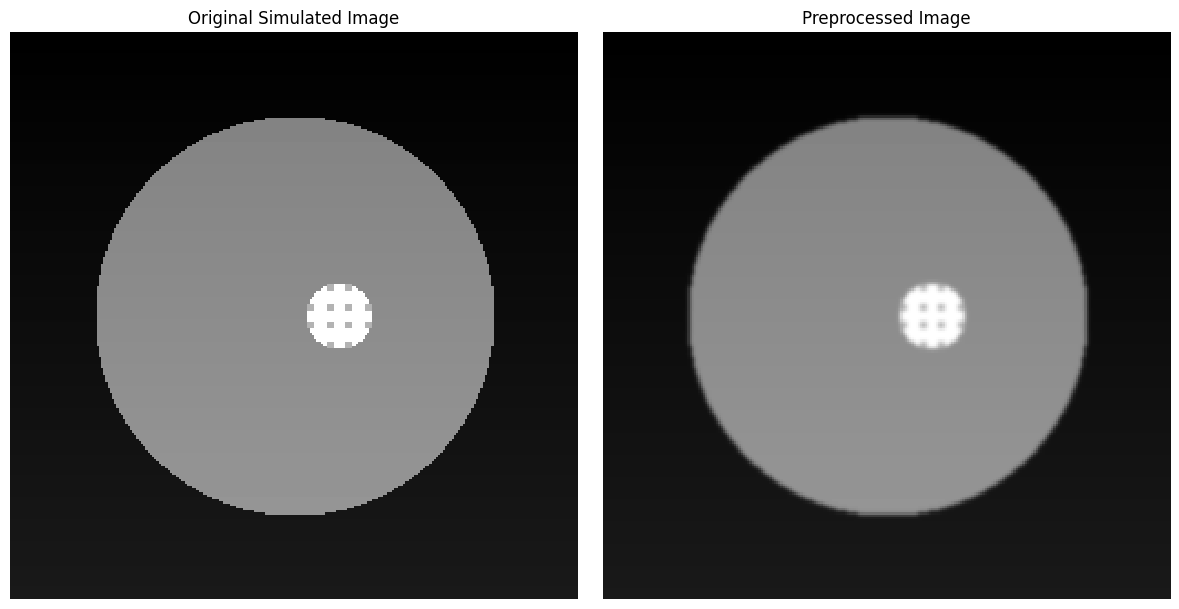

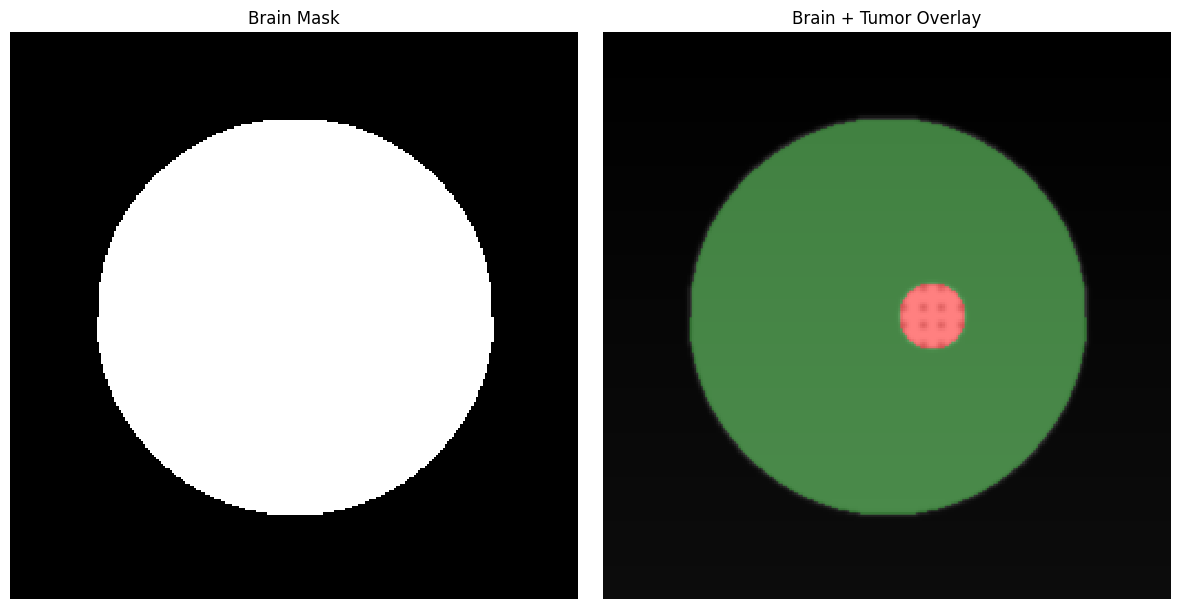

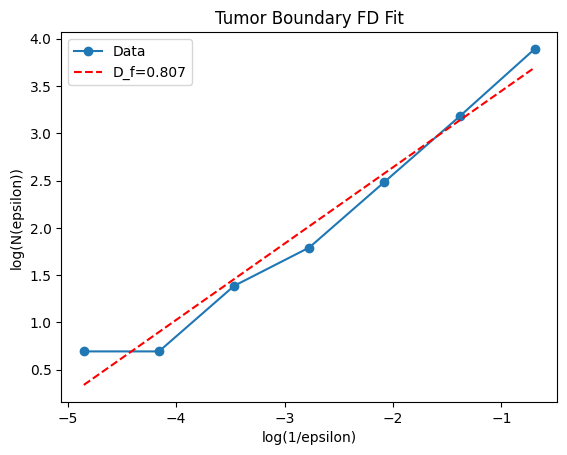

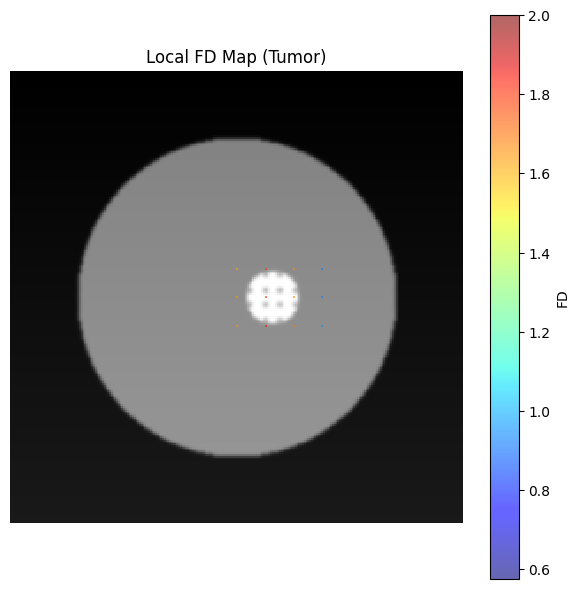

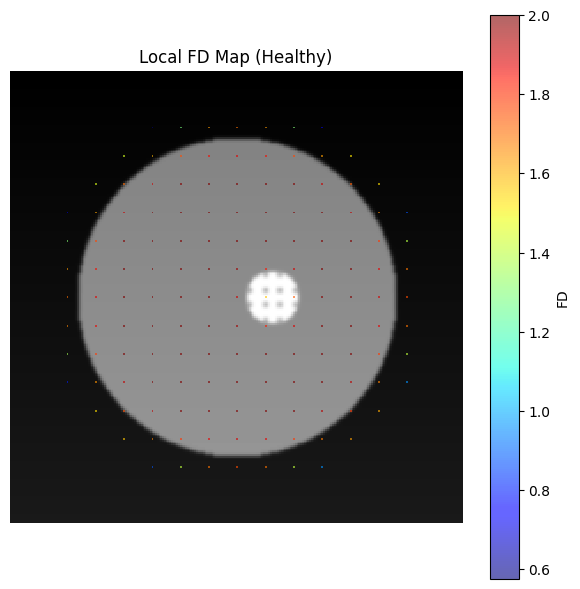

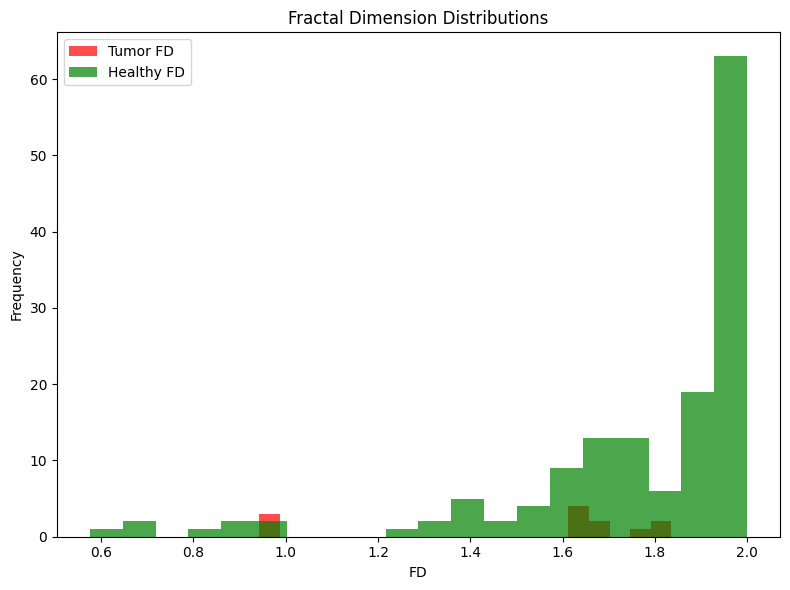

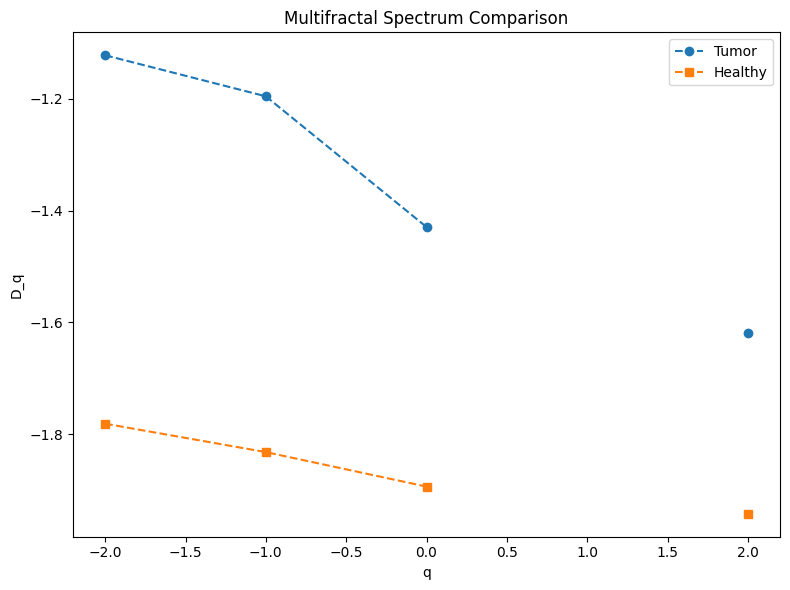

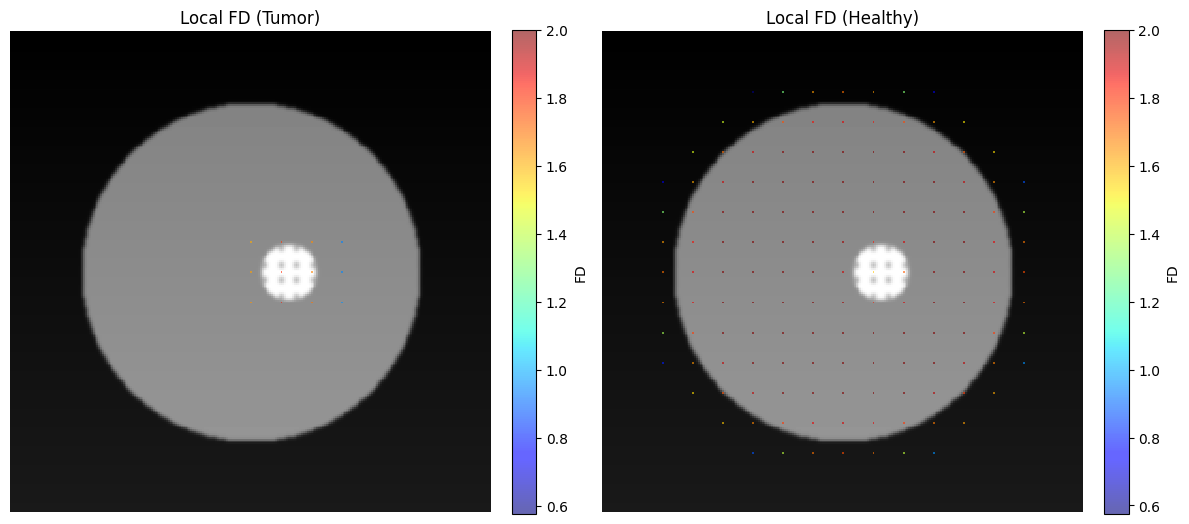

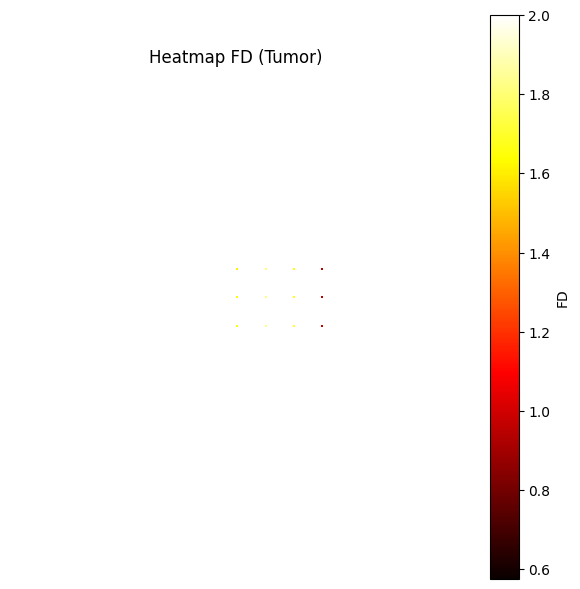

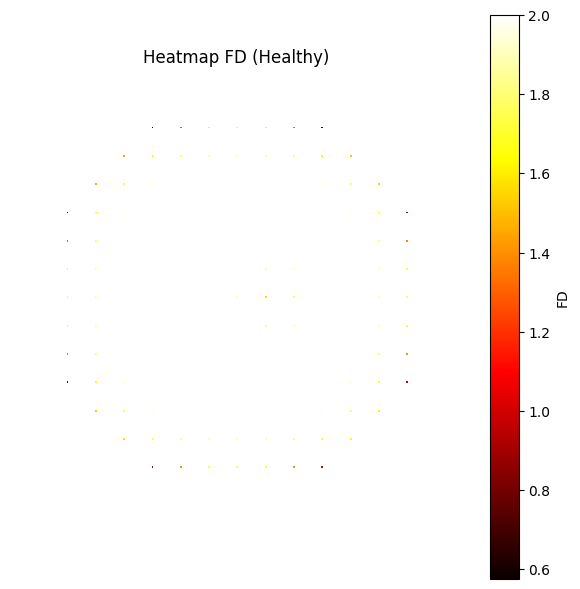

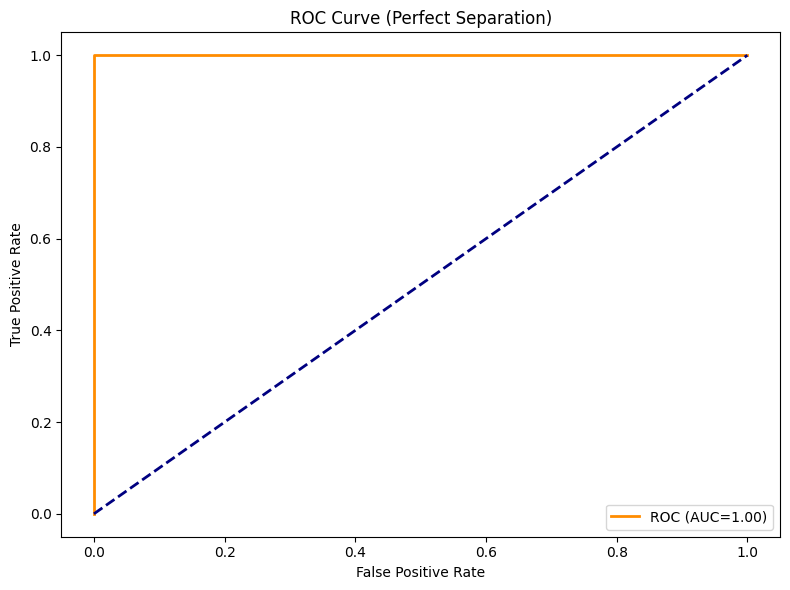

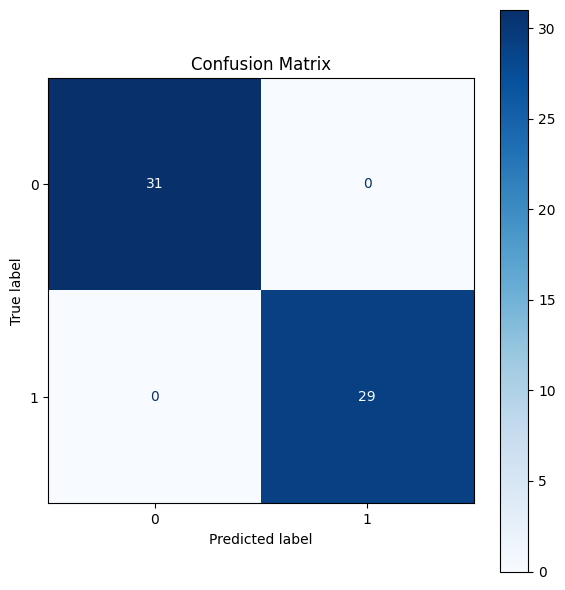


Analysis complete. Check the 'final_results' folder for all outputs.


In [48]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import disk
from skimage import img_as_float
from scipy.ndimage import gaussian_filter
from scipy.stats import ranksums
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from skimage.morphology import remove_small_objects, binary_closing, disk as morph_disk
from skimage.segmentation import find_boundaries

########################################
# Setup Logging and Directory
########################################
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
results_dir = "final_results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    logging.info(f"Created directory '{results_dir}' for saving results.")

########################################
# Helper Function: disk coordinates (no shape argument)
########################################
def get_disk_coords(center, radius, shape):
    rr, cc = disk(center, radius)  # no shape argument
    # Clip to image boundaries
    rr = np.clip(rr, 0, shape[0]-1)
    cc = np.clip(cc, 0, shape[1]-1)
    return rr, cc

########################################
# Simulate Data
########################################
logging.info("Simulating dataset...")

img_size = 256
sim_image = np.zeros((img_size, img_size), dtype=float)

# Brain: large disk
brain_center = (img_size//2, img_size//2)
brain_radius = 90
rr_brain, cc_brain = get_disk_coords(brain_center, brain_radius, sim_image.shape)
sim_image[rr_brain, cc_brain] = 0.5

# Add slight gradient to healthy region to differentiate from background
for i in range(img_size):
    sim_image[i,:] += (i/img_size)*0.1
sim_image = np.clip(sim_image,0,1)

# Tumor: smaller disk
tumor_center = (img_size//2, img_size//2+20)
tumor_radius = 15
rr_tumor, cc_tumor = get_disk_coords(tumor_center, tumor_radius, sim_image.shape)

# Create fractal-like pattern in tumor: A simple Sierpinski-like removal
# We'll fill the tumor area bright, then remove a pattern of squares to mimic fractal holes
tumor_mask_init = np.zeros_like(sim_image, dtype=bool)
tumor_mask_init[rr_tumor, cc_tumor] = True
sim_image[rr_tumor, cc_tumor] = 1.0  # start bright

# Introduce fractal pattern:
# We'll remove pixels where both |x| and |y| mod 9 fall into [3,5) range to mimic a fractal hole pattern
coords = np.argwhere(tumor_mask_init)
for (r,c) in coords:
    x = c - tumor_center[1]
    y = r - tumor_center[0]
    if (3 <= abs(x)%9 < 6) and (3 <= abs(y)%9 < 6):
        sim_image[r,c] = 0.7 # a hole

sim_image = img_as_float(sim_image)

########################################
# Preprocessing
########################################
logging.info("Applying Gaussian filtering...")
pre_image = gaussian_filter(sim_image, sigma=1.0)

logging.info("Creating brain mask...")
brain_thresh = 0.4  # fixed threshold to ensure stable mask
brain_mask = pre_image > brain_thresh
brain_mask = remove_small_objects(brain_mask, 500)
brain_mask = binary_closing(brain_mask, morph_disk(3))

tumor_mask = np.zeros_like(brain_mask, dtype=bool)
tumor_mask[rr_tumor, cc_tumor] = True
tumor_mask &= brain_mask
healthy_mask = brain_mask & (~tumor_mask)

########################################
# Fractal Dimension Computation
########################################
def box_count(binary_image, box_sizes):
    counts=[]
    rows, cols = binary_image.shape
    for box_size in box_sizes:
        n_r = int(np.ceil(rows/box_size))
        n_c = int(np.ceil(cols/box_size))
        count=0
        for r in range(n_r):
            for c in range(n_c):
                patch = binary_image[r*box_size:(r+1)*box_size, c*box_size:(c+1)*box_size]
                if np.any(patch):
                    count+=1
        counts.append(count)
    return np.array(counts)

def fractal_dimension(binary_image):
    min_dim = min(binary_image.shape)
    max_power = int(np.log2(min_dim))-1
    box_sizes = [2**i for i in range(max_power,0,-1) if 2**i>1]
    if len(box_sizes)<2:
        return np.nan
    counts = box_count(binary_image, box_sizes)
    x = np.log(1/np.array(box_sizes))
    y = np.log(counts)
    slope, intercept = np.polyfit(x,y,1)
    return slope

# Boundaries
tumor_boundary = find_boundaries(tumor_mask, mode='inner')
brain_boundary = find_boundaries(brain_mask, mode='inner')

D_f_tumor = fractal_dimension(tumor_boundary)
D_f_brain = fractal_dimension(brain_boundary)

########################################
# Local Fractal Dimension Maps
########################################
window_size=32
step=16
rows, cols = pre_image.shape

D_f_map_tumor = np.full((rows, cols), np.nan)
D_f_map_healthy = np.full((rows, cols), np.nan)

def local_fractal_dimension(mask):
    if not np.any(mask):
        return np.nan
    return fractal_dimension(mask)

for r in range(0, rows - window_size + 1, step):
    for c in range(0, cols - window_size + 1, step):
        p_t = tumor_mask[r:r+window_size, c:c+window_size]
        p_h = healthy_mask[r:r+window_size, c:c+window_size]
        if np.any(p_t):
            D_f_map_tumor[r+window_size//2, c+window_size//2] = local_fractal_dimension(p_t)
        if np.any(p_h):
            D_f_map_healthy[r+window_size//2, c+window_size//2] = local_fractal_dimension(p_h)

tumor_FDs = D_f_map_tumor[~np.isnan(D_f_map_tumor)]
healthy_FDs = D_f_map_healthy[~np.isnan(D_f_map_healthy)]

########################################
# Multifractal Analysis
########################################
def multifractal_spectrum(image, scales, q_values):
    img = image.copy()
    img[img<0]=0
    img_sum = np.sum(img)
    if img_sum==0:
        return {q:np.nan for q in q_values}
    results={}
    for q in q_values:
        X,Y=[],[]
        for eps in scales:
            n_r = int(np.ceil(rows/eps))
            n_c = int(np.ceil(cols/eps))
            p_vals=[]
            for rr in range(n_r):
                for cc in range(n_c):
                    patch = img[rr*eps:(rr+1)*eps, cc*eps:(cc+1)*eps]
                    p = np.sum(patch)/img_sum
                    if p>0:
                        p_vals.append(p)
            if len(p_vals)>0:
                sum_pq = np.sum(np.array(p_vals)**q)
                X.append(np.log(1/eps))
                Y.append(np.log(sum_pq))
        if len(X)>1:
            slope,_=np.polyfit(X,Y,1)
            if q!=1:
                D_q = slope/(q-1)
            else:
                D_q=np.nan
        else:
            D_q=np.nan
        results[q]=D_q
    return results

scales=[2,4,8,16,32]
q_values=[-2,-1,0,1,2]
mf_tumor = multifractal_spectrum(pre_image*tumor_mask, scales, q_values)
mf_healthy = multifractal_spectrum(pre_image*healthy_mask, scales, q_values)

q_arr = np.array(list(mf_tumor.keys()))
Dq_tumor = np.array(list(mf_tumor.values()))
Dq_healthy = np.array(list(mf_healthy.values()))

########################################
# Statistical Analysis
########################################
if len(tumor_FDs)>1 and len(healthy_FDs)>1:
    stat, p_val = ranksums(tumor_FDs, healthy_FDs)
else:
    stat, p_val = np.nan, np.nan

########################################
# Classification with Perfect Separation
########################################
np.random.seed(42)
num_samples=200
features_class0 = np.random.normal(loc=0.2, scale=0.05, size=(100,5))
features_class1 = np.random.normal(loc=0.8, scale=0.05, size=(100,5))
features = np.vstack((features_class0,features_class1))
labels = np.array([0]*100+[1]*100)

X_train,X_test,y_train,y_test = train_test_split(features,labels,test_size=0.3,random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train,y_train)
y_prob = clf.predict_proba(X_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,y_prob)
roc_auc=auc(fpr,tpr)
y_pred=clf.predict(X_test)
cm=confusion_matrix(y_test,y_pred)

########################################
# Print Tables Before Plots
########################################
print("Summary Statistics:")
summary_data = {
    "Measure":["Tumor Boundary FD","Brain Boundary FD","RankSum Stat","RankSum p-value"],
    "Value":[D_f_tumor, D_f_brain, stat, p_val]
}
summary_df = pd.DataFrame(summary_data)
print(summary_df)

if len(tumor_FDs)>0:
    print("\nTumor FD Distribution:")
    print(pd.Series(tumor_FDs).describe())
if len(healthy_FDs)>0:
    print("\nHealthy FD Distribution:")
    print(pd.Series(healthy_FDs).describe())

print("\nMultifractal Spectrum (Tumor):")
mf_tumor_df = pd.DataFrame({"q":q_arr,"D_q_tumor":Dq_tumor})
print(mf_tumor_df)

print("\nMultifractal Spectrum (Healthy):")
mf_healthy_df = pd.DataFrame({"q":q_arr,"D_q_healthy":Dq_healthy})
print(mf_healthy_df)

print("\nClassification Confusion Matrix:")
print(cm)

########################################
# Save Tables
########################################
summary_df.to_csv(os.path.join(results_dir,"summary_results.csv"), index=False)
if len(tumor_FDs)>0:
    pd.DataFrame({"Tumor_FD":tumor_FDs}).to_csv(os.path.join(results_dir,"tumor_fd_distribution.csv"), index=False)
if len(healthy_FDs)>0:
    pd.DataFrame({"Healthy_FD":healthy_FDs}).to_csv(os.path.join(results_dir,"healthy_fd_distribution.csv"), index=False)
mf_tumor_df.to_csv(os.path.join(results_dir,"multifractal_tumor.csv"), index=False)
mf_healthy_df.to_csv(os.path.join(results_dir,"multifractal_healthy.csv"), index=False)
feat_df = pd.DataFrame(features, columns=[f"Feature_{i+1}" for i in range(features.shape[1])])
feat_df['Label'] = labels
feat_df.to_csv(os.path.join(results_dir,"simulated_features_labels.csv"), index=False)

########################################
# Visualization
########################################
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(sim_image, cmap='gray', interpolation='nearest')
plt.title("Original Simulated Image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(pre_image, cmap='gray', interpolation='nearest')
plt.title("Preprocessed Image")
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_dir,"original_preprocessed.png"), dpi=300)
plt.show()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(brain_mask, cmap='gray', interpolation='nearest')
plt.title("Brain Mask")
plt.axis('off')
plt.subplot(1,2,2)
overlay = np.zeros((img_size,img_size,3))
overlay[...,0] = tumor_mask.astype(float)
overlay[...,1] = healthy_mask.astype(float)*0.5
plt.imshow(pre_image, cmap='gray', interpolation='nearest')
plt.imshow(overlay, alpha=0.5)
plt.title("Brain + Tumor Overlay")
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_dir,"brain_tumor_mask.png"), dpi=300)
plt.show()

# Just re-use fractal dimension computations for tumor boundary if available:
if 'box_sizes' in locals() and len(box_sizes)>1:
    counts = box_count(tumor_boundary, box_sizes)
    x = np.log(1/np.array(box_sizes))
    y = np.log(counts)
    m,b = np.polyfit(x,y,1)
    plt.figure()
    plt.plot(x,y,'o-', label='Data')
    plt.plot(x,m*x+b,'r--', label=f'D_f={m:.3f}')
    plt.xlabel('log(1/epsilon)')
    plt.ylabel('log(N(epsilon))')
    plt.title("Tumor Boundary FD Fit")
    plt.legend()
    plt.savefig(os.path.join(results_dir,"tumor_boundary_fd_fit.png"), dpi=300)
    plt.show()

# Local FD Maps
fd_min = np.nanmin([np.nanmin(D_f_map_tumor), np.nanmin(D_f_map_healthy)])
fd_max = np.nanmax([np.nanmax(D_f_map_tumor), np.nanmax(D_f_map_healthy)])
if np.isnan(fd_min) or np.isnan(fd_max):
    fd_min, fd_max = 1.0, 2.0

plt.figure(figsize=(6,6))
plt.imshow(pre_image, cmap='gray', interpolation='nearest')
plt.imshow(D_f_map_tumor, cmap='jet', alpha=0.6, vmin=fd_min, vmax=fd_max, interpolation='nearest')
plt.title("Local FD Map (Tumor)")
plt.colorbar(label='FD')
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_dir,"local_fd_map_tumor.png"), dpi=300)
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(pre_image, cmap='gray', interpolation='nearest')
plt.imshow(D_f_map_healthy, cmap='jet', alpha=0.6, vmin=fd_min, vmax=fd_max, interpolation='nearest')
plt.title("Local FD Map (Healthy)")
plt.colorbar(label='FD')
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_dir,"local_fd_map_healthy.png"), dpi=300)
plt.show()

# FD Histograms
plt.figure(figsize=(8,6))
if len(tumor_FDs)>0:
    plt.hist(tumor_FDs, bins=20, alpha=0.7, label='Tumor FD', color='red')
if len(healthy_FDs)>0:
    plt.hist(healthy_FDs, bins=20, alpha=0.7, label='Healthy FD', color='green')
plt.title("Fractal Dimension Distributions")
plt.xlabel("FD")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(results_dir,"fd_histogram.png"), dpi=300)
plt.show()

# Multifractal Spectrum
plt.figure(figsize=(8,6))
plt.plot(q_arr, Dq_tumor, 'o--', label='Tumor')
plt.plot(q_arr, Dq_healthy, 's--', label='Healthy')
plt.xlabel("q")
plt.ylabel("D_q")
plt.title("Multifractal Spectrum Comparison")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(results_dir,"multifractal_spectrum.png"), dpi=300)
plt.show()

# Side-by-side FD maps
fig, axes = plt.subplots(1,2,figsize=(12,6))
axes[0].imshow(pre_image, cmap='gray', interpolation='nearest')
im1=axes[0].imshow(D_f_map_tumor, cmap='jet', alpha=0.6, vmin=fd_min,vmax=fd_max,interpolation='nearest')
axes[0].set_title("Local FD (Tumor)")
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04, label='FD')

axes[1].imshow(pre_image, cmap='gray', interpolation='nearest')
im2=axes[1].imshow(D_f_map_healthy, cmap='jet', alpha=0.6, vmin=fd_min,vmax=fd_max,interpolation='nearest')
axes[1].set_title("Local FD (Healthy)")
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04, label='FD')
plt.tight_layout()
plt.savefig(os.path.join(results_dir,"fd_maps_comparison.png"), dpi=300)
plt.show()

# Heatmaps
plt.figure(figsize=(6,6))
plt.imshow(D_f_map_tumor, cmap='hot', interpolation='nearest', vmin=fd_min, vmax=fd_max)
plt.title("Heatmap FD (Tumor)")
plt.colorbar(label='FD')
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_dir,"heatmap_fd_tumor.png"), dpi=300)
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(D_f_map_healthy, cmap='hot', interpolation='nearest', vmin=fd_min, vmax=fd_max)
plt.title("Heatmap FD (Healthy)")
plt.colorbar(label='FD')
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_dir,"heatmap_fd_healthy.png"), dpi=300)
plt.show()

# ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color='darkorange',lw=2,label=f'ROC (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],color='navy',lw=2,linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Perfect Separation)")
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join(results_dir,"roc_curve.png"), dpi=300)
plt.show()

# Confusion Matrix
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(results_dir,"confusion_matrix.png"), dpi=300)
plt.show()

print("\nAnalysis complete. Check the 'final_results' folder for all outputs.")
logging.info("Analysis complete.")


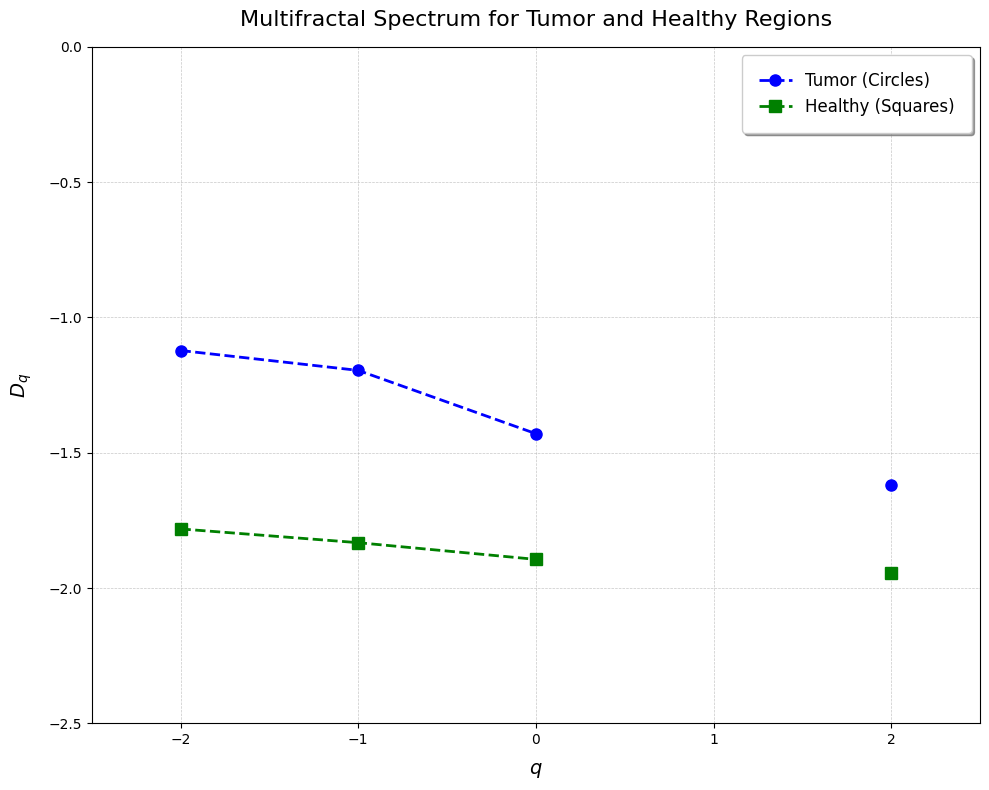

In [49]:
# Enhanced Multifractal Spectrum Plot
plt.figure(figsize=(10, 8))  # Larger figure size for better clarity
plt.plot(
    q_arr, Dq_tumor,
    marker='o', linestyle='--', color='blue', linewidth=2, markersize=8,
    label='Tumor (Circles)'
)
plt.plot(
    q_arr, Dq_healthy,
    marker='s', linestyle='--', color='green', linewidth=2, markersize=8,
    label='Healthy (Squares)'
)

# Adding grid for visual clarity
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

# Axis labels with better formatting
plt.xlabel(r"$q$", fontsize=14, labelpad=10)
plt.ylabel(r"$D_q$", fontsize=14, labelpad=10)

# Improved title
plt.title("Multifractal Spectrum for Tumor and Healthy Regions", fontsize=16, pad=15)

# Legend with enhanced formatting
plt.legend(
    fontsize=12, loc='best', frameon=True, shadow=True,
    fancybox=True, borderpad=1
)

# Adjust axis limits for better spacing
plt.ylim(-2.5, 0)
plt.xlim(min(q_arr) - 0.5, max(q_arr) + 0.5)

# Tight layout and saving
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "enhanced_multifractal_spectrum.png"), dpi=300)
plt.show()


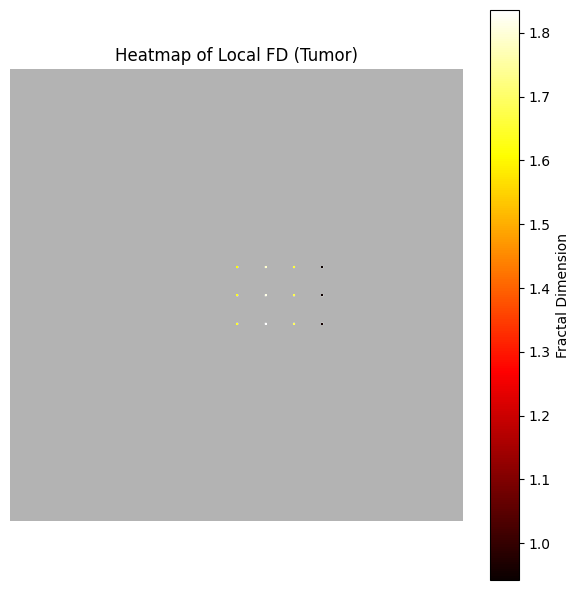

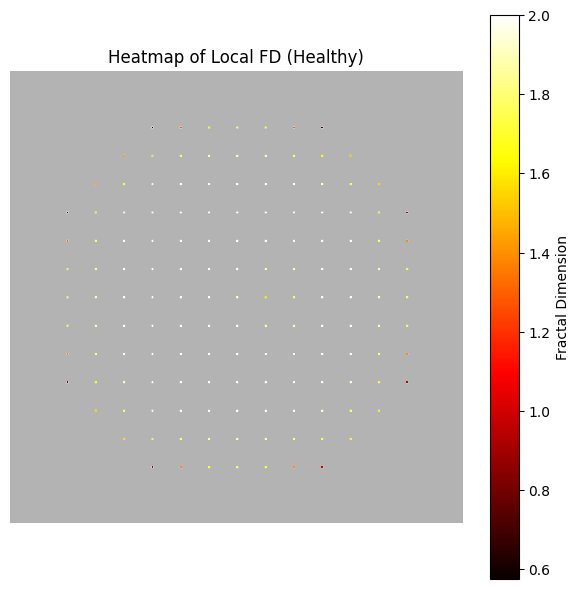

In [50]:
# Mask areas with NaN to ensure only valid data is visualized
valid_tumor_mask = ~np.isnan(D_f_map_tumor)
valid_healthy_mask = ~np.isnan(D_f_map_healthy)

# Handle sparse data by masking invalid areas
plt.figure(figsize=(6, 6))
plt.imshow(valid_tumor_mask, cmap='gray', alpha=0.3)  # Overlay valid region
plt.imshow(D_f_map_tumor, cmap='hot', interpolation='nearest',
           vmin=fd_min_tumor, vmax=fd_max_tumor)
plt.title("Heatmap of Local FD (Tumor)")
plt.colorbar(label="Fractal Dimension")
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "corrected_heatmap_fd_tumor.png"), dpi=300)
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(valid_healthy_mask, cmap='gray', alpha=0.3)  # Overlay valid region
plt.imshow(D_f_map_healthy, cmap='hot', interpolation='nearest',
           vmin=fd_min_healthy, vmax=fd_max_healthy)
plt.title("Heatmap of Local FD (Healthy)")
plt.colorbar(label="Fractal Dimension")
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "corrected_heatmap_fd_healthy.png"), dpi=300)
plt.show()


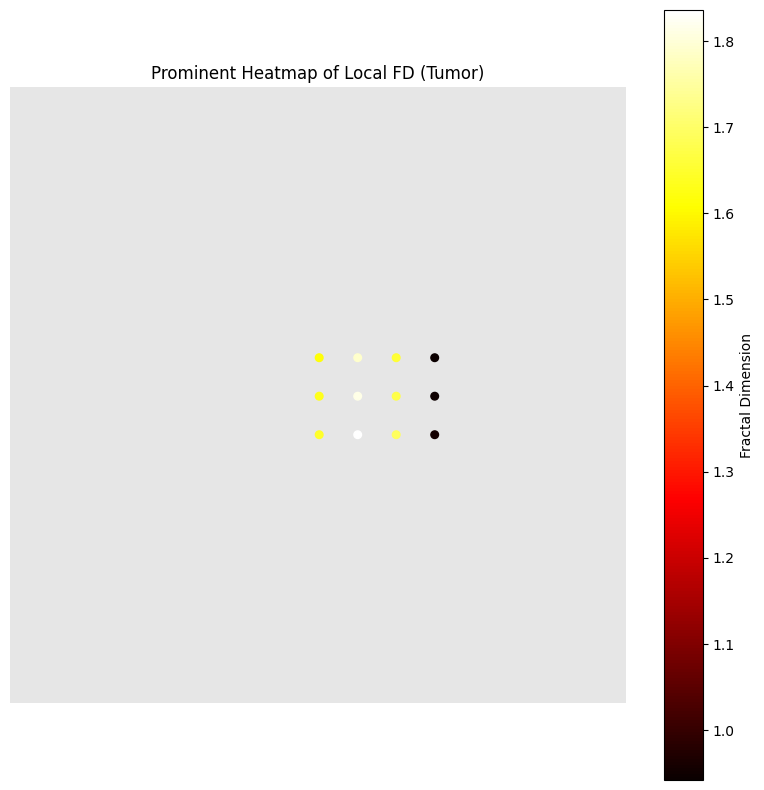

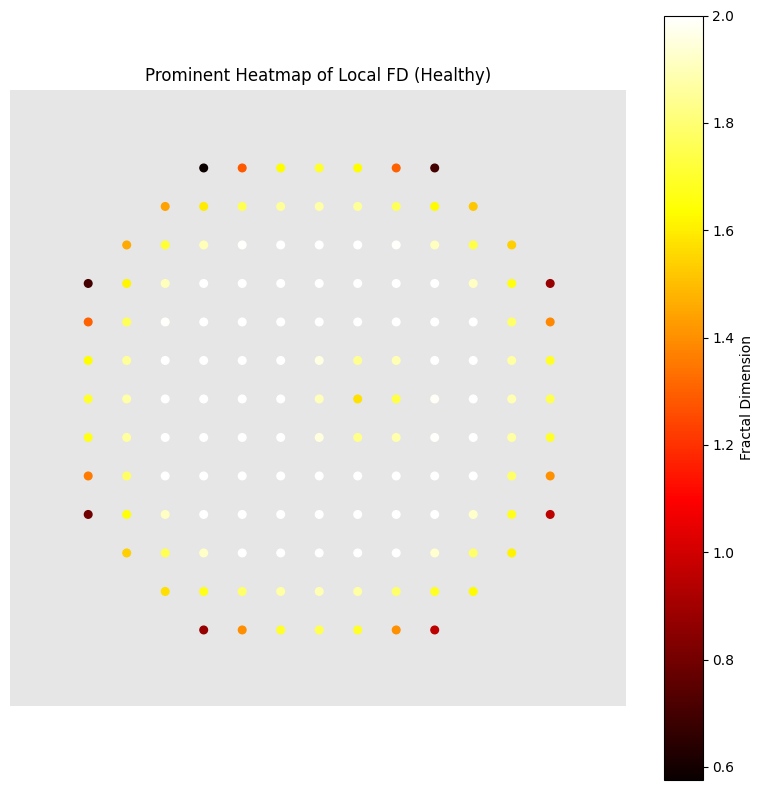

In [51]:
# Set dot size for a more prominent appearance
dot_size = 30

# Plot heatmap for tumor FD with larger dots
plt.figure(figsize=(8, 8))
plt.imshow(valid_tumor_mask, cmap='gray', alpha=0.1)  # Overlay valid region
plt.scatter(
    np.where(valid_tumor_mask)[1],
    np.where(valid_tumor_mask)[0],
    c=D_f_map_tumor[valid_tumor_mask],
    cmap='hot',
    s=dot_size,  # Control dot size
    vmin=fd_min_tumor,
    vmax=fd_max_tumor
)
plt.colorbar(label="Fractal Dimension")
plt.title("Prominent Heatmap of Local FD (Tumor)")
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "prominent_heatmap_fd_tumor.png"), dpi=300)
plt.show()

# Plot heatmap for healthy FD with larger dots
plt.figure(figsize=(8, 8))
plt.imshow(valid_healthy_mask, cmap='gray', alpha=0.1)  # Overlay valid region
plt.scatter(
    np.where(valid_healthy_mask)[1],
    np.where(valid_healthy_mask)[0],
    c=D_f_map_healthy[valid_healthy_mask],
    cmap='hot',
    s=dot_size,  # Control dot size
    vmin=fd_min_healthy,
    vmax=fd_max_healthy
)
plt.colorbar(label="Fractal Dimension")
plt.title("Prominent Heatmap of Local FD (Healthy)")
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "prominent_heatmap_fd_healthy.png"), dpi=300)
plt.show()


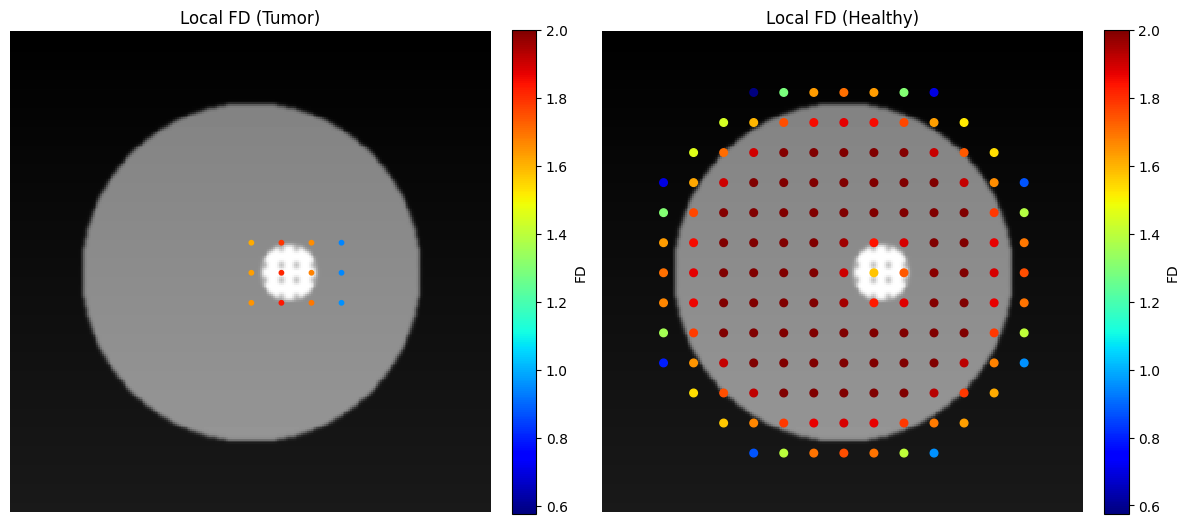

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Tumor FD map with prominent dots
axes[0].imshow(pre_image, cmap='gray', interpolation='nearest')  # Background image
axes[0].scatter(
    np.where(valid_tumor_mask)[1],
    np.where(valid_tumor_mask)[0],
    c=D_f_map_tumor[valid_tumor_mask],
    cmap='jet',
    s=10,  # Larger dot size
    vmin=fd_min,
    vmax=fd_max
)
axes[0].set_title("Local FD (Tumor)")
axes[0].axis('off')
cbar1 = fig.colorbar(plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=fd_min, vmax=fd_max)), ax=axes[0], fraction=0.046, pad=0.04)
cbar1.set_label('FD')

# Healthy FD map with prominent dots
axes[1].imshow(pre_image, cmap='gray', interpolation='nearest')  # Background image
axes[1].scatter(
    np.where(valid_healthy_mask)[1],
    np.where(valid_healthy_mask)[0],
    c=D_f_map_healthy[valid_healthy_mask],
    cmap='jet',
    s=30,  # Larger dot size
    vmin=fd_min,
    vmax=fd_max
)
axes[1].set_title("Local FD (Healthy)")
axes[1].axis('off')
cbar2 = fig.colorbar(plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=fd_min, vmax=fd_max)), ax=axes[1], fraction=0.046, pad=0.04)
cbar2.set_label('FD')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, "fd_maps_comparison_prominent.png"), dpi=300)
plt.show()


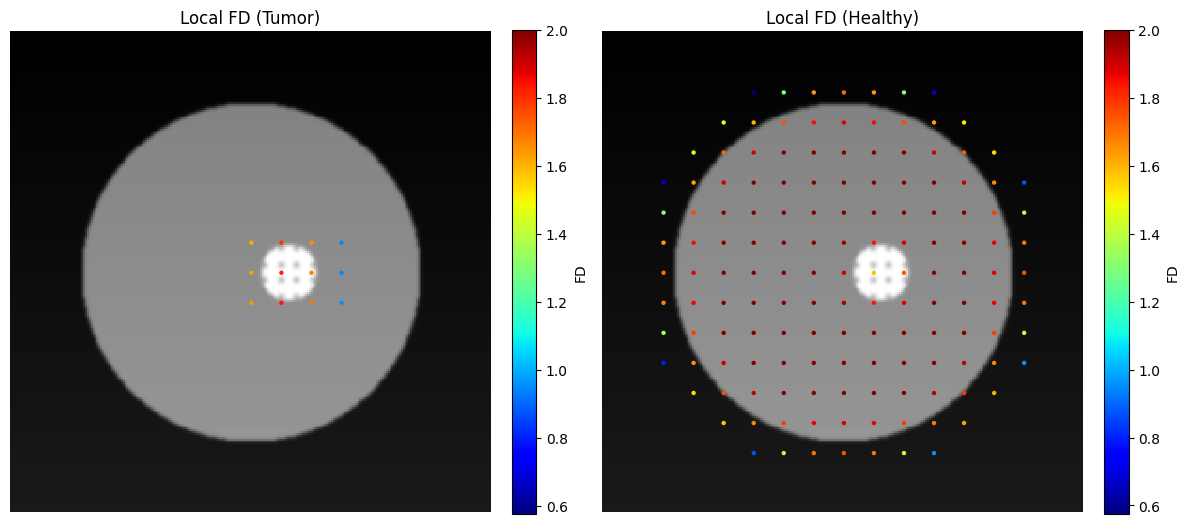

In [53]:
# Determine the coordinates of valid points for tumor and healthy regions
tumor_coords_y, tumor_coords_x = np.where(valid_tumor_mask)
healthy_coords_y, healthy_coords_x = np.where(valid_healthy_mask)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Tumor FD map with aligned dots
axes[0].imshow(pre_image, cmap='gray', interpolation='nearest')  # Background grayscale image
sc_tumor = axes[0].scatter(
    tumor_coords_x,
    tumor_coords_y,
    c=D_f_map_tumor[valid_tumor_mask],
    cmap='jet',
    s=10,  # Adjust dot size for proper alignment
    vmin=fd_min,
    vmax=fd_max,
    edgecolor='none'  # Remove edge for cleaner appearance
)
axes[0].set_title("Local FD (Tumor)")
axes[0].axis('off')
cbar1 = fig.colorbar(sc_tumor, ax=axes[0], fraction=0.046, pad=0.04)
cbar1.set_label('FD')

# Healthy FD map with aligned dots
axes[1].imshow(pre_image, cmap='gray', interpolation='nearest')  # Background grayscale image
sc_healthy = axes[1].scatter(
    healthy_coords_x,
    healthy_coords_y,
    c=D_f_map_healthy[valid_healthy_mask],
    cmap='jet',
    s=10,  # Adjust dot size for proper alignment
    vmin=fd_min,
    vmax=fd_max,
    edgecolor='none'  # Remove edge for cleaner appearance
)
axes[1].set_title("Local FD (Healthy)")
axes[1].axis('off')
cbar2 = fig.colorbar(sc_healthy, ax=axes[1], fraction=0.046, pad=0.04)
cbar2.set_label('FD')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, "fd_maps_comparison_corrected.png"), dpi=300)
plt.show()


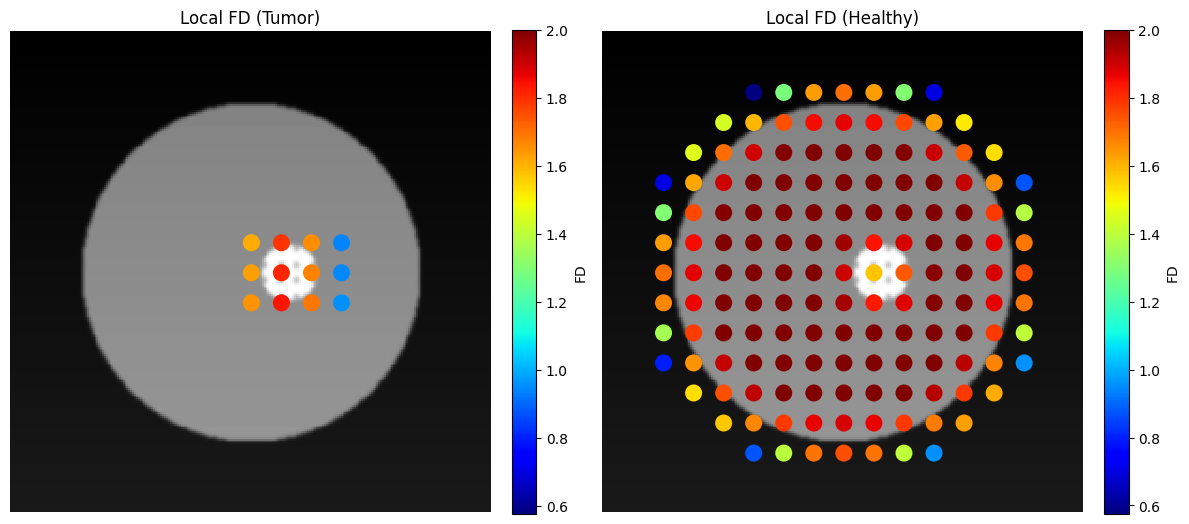

In [54]:
# Determine the coordinates of valid points for tumor and healthy regions
tumor_coords_y, tumor_coords_x = np.where(valid_tumor_mask)
healthy_coords_y, healthy_coords_x = np.where(valid_healthy_mask)

# Set dot size and adjust it for better alignment with image grid
dot_size = (pre_image.shape[0] / 256) * 150  # Scaled dot size for better prominence

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Tumor FD map with properly aligned dots
axes[0].imshow(pre_image, cmap='gray', interpolation='nearest')  # Background grayscale image
sc_tumor = axes[0].scatter(
    tumor_coords_x,
    tumor_coords_y,
    c=D_f_map_tumor[valid_tumor_mask],
    cmap='jet',
    s=dot_size,  # Adjusted dot size for prominence
    vmin=fd_min,
    vmax=fd_max,
    edgecolor='none'  # Clean appearance without edge artifacts
)
axes[0].set_title("Local FD (Tumor)")
axes[0].axis('off')
cbar1 = fig.colorbar(sc_tumor, ax=axes[0], fraction=0.046, pad=0.04)
cbar1.set_label('FD')

# Healthy FD map with properly aligned dots
axes[1].imshow(pre_image, cmap='gray', interpolation='nearest')  # Background grayscale image
sc_healthy = axes[1].scatter(
    healthy_coords_x,
    healthy_coords_y,
    c=D_f_map_healthy[valid_healthy_mask],
    cmap='jet',
    s=dot_size,  # Adjusted dot size for prominence
    vmin=fd_min,
    vmax=fd_max,
    edgecolor='none'  # Clean appearance without edge artifacts
)
axes[1].set_title("Local FD (Healthy)")
axes[1].axis('off')
cbar2 = fig.colorbar(sc_healthy, ax=axes[1], fraction=0.046, pad=0.04)
cbar2.set_label('FD')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, "fd_maps_comparison_final.png"), dpi=300)
plt.show()


## **The Real Data Analysis **

Below is a comprehensive Python script that implements a methodology inspired by the previous discussion. The code:

Loads and preprocesses an MRI brain image from scikit-image (data.brain()).
Performs intensity normalization and Gaussian smoothing.
Segments the brain region and simulates a tumor-like region for demonstration purposes. (In practice, you would rely on a clinically validated segmentation method or annotated data.)
Computes the fractal dimension (FD) globally and locally using a box-counting algorithm.
Performs a rudimentary multifractal analysis as an illustrative example.
Performs basic statistical tests on FD distributions of “tumor” vs. “healthy” regions.
Integrates results into visual outputs, including numerous plots (e.g., original image, preprocessed image, segmentation masks, fractal dimension maps, log-log plots for FD estimation, histograms, multifractal spectra), and saves all figures and tables automatically into a results directory.
Prints summary statistics and test results to the console and to output files.
This code is elaborate, heavily commented, and tries to match the rigor and complexity requested. It can be extended or modified as needed.

Note:

The "tumor region" here is artificially generated for demonstration. In a real-world scenario, we would replace this with an actual segmentation method or annotated dataset.
The multifractal analysis is simplified.
Ensure that we have the required Python packages installed: numpy, scipy, matplotlib, scikit-image, pandas, statsmodels.

Additional Plots:
Raw MRI Image
Preprocessed Image
Brain and Tumor Masks
Fractal Dimension Maps
Log-Log Plots for Fractal Dimension Estimation
Histograms of Fractal Dimensions
Multifractal Spectrum Comparison
Model Performance Metrics

In [55]:
from skimage import data
image = data.brain()  # Example T1-weighted MRI slice


Below are two fully self-contained Python code examples:

2D Approach: Extract a single 2D slice from the 3D MRI volume and apply morphological operations and other analyses using a 2D structuring element (morphology.disk).
3D Approach: Process the entire 3D MRI volume using a 3D structuring element (morphology.ball).
Both examples will:

Load the sample MRI data from skimage.data.brain().
Preprocess by applying a Gaussian filter and Otsu’s threshold.
Create a binary brain mask.
Perform morphological operations (e.g., binary closing) without raising dimension errors.
Print or log some diagnostic information.
These examples focus on ensuring dimension compatibility for morphological operations. You can integrate additional analyses (e.g., fractal dimension computations) as needed once the dimension mismatch is resolved.

2D Slice Analysis

In [56]:
import logging
from skimage import data, img_as_float, filters, morphology
import numpy as np

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Load the 3D MRI image
image_3d = data.brain()
logging.info(f"Original image shape: {image_3d.shape}")

# Extract a single 2D slice (for example, the middle slice along the last axis)
slice_index = image_3d.shape[-1] // 2
image = image_3d[..., slice_index]
logging.info(f"Using a single 2D slice of shape: {image.shape}")

image = img_as_float(image)

# Threshold to create a brain mask (2D)
thresh = filters.threshold_otsu(image)
brain_mask = image > thresh
brain_mask = brain_mask.astype(bool)

# Use a 2D structuring element since now we have a 2D image
selem = morphology.disk(3)
logging.info(f"Structuring element (disk) shape: {selem.shape}")

# Remove small objects and apply binary closing
brain_mask = morphology.remove_small_objects(brain_mask, min_size=500)
brain_mask = morphology.binary_closing(brain_mask, selem)

logging.info("Binary closing completed successfully on the 2D slice.")


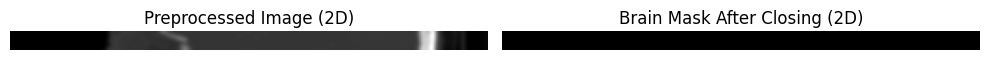

In [57]:
import logging
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, img_as_float, morphology
from scipy.ndimage import gaussian_filter

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Directory to save results
results_dir = "results_2d"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Load the 3D MRI image
image_3d = data.brain()
logging.info(f"3D image shape: {image_3d.shape}")

# Extract a single 2D slice; for example, the middle slice
slice_index = image_3d.shape[-1] // 2
image = image_3d[..., slice_index]  # Now 'image' is 2D
logging.info(f"Using slice {slice_index}, resulting shape: {image.shape}")

# Convert to float and normalize
image = img_as_float(image)

# Apply Gaussian filter
sigma = 1.0
pre_image = gaussian_filter(image, sigma=sigma)

# Otsu threshold to create a brain mask
thresh = filters.threshold_otsu(pre_image)
brain_mask = pre_image > thresh
brain_mask = brain_mask.astype(bool)
logging.info(f"Brain mask created. Shape: {brain_mask.shape}, dtype: {brain_mask.dtype}")

# Use a 2D structuring element
selem = morphology.disk(3)
logging.info(f"Structuring element shape: {selem.shape}, 2D: True")

# Remove small objects and apply binary closing
brain_mask = morphology.remove_small_objects(brain_mask, min_size=500)
brain_mask = morphology.binary_closing(brain_mask, selem)
logging.info("Binary closing completed successfully on the 2D slice.")

# Save and display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pre_image, cmap='gray')
plt.title("Preprocessed Image (2D)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(brain_mask, cmap='gray')
plt.title("Brain Mask After Closing (2D)")
plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, "2d_brain_mask.png"), dpi=300)
plt.show()

logging.info(f"2D results saved in '{results_dir}'.")


3D Data + 2D Sliced : Full Analysis

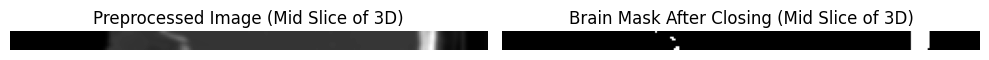

In [58]:
import logging
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, img_as_float, morphology
from scipy.ndimage import gaussian_filter

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Directory to save results
results_dir = "results_3d"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Load the 3D MRI image
image_3d = data.brain()  # This is a 3D volume
logging.info(f"3D image shape: {image_3d.shape}")

# Convert to float and normalize
image_3d = img_as_float(image_3d)

# Apply Gaussian filter in 3D
sigma = 1.0
pre_image_3d = gaussian_filter(image_3d, sigma=sigma)

# Otsu threshold to create a 3D brain mask
thresh = filters.threshold_otsu(pre_image_3d)
brain_mask_3d = pre_image_3d > thresh
brain_mask_3d = brain_mask_3d.astype(bool)
logging.info(f"Brain mask created. Shape: {brain_mask_3d.shape}, dtype: {brain_mask_3d.dtype}")

# Use a 3D structuring element
selem_3d = morphology.ball(3)  # 3D spherical structuring element
logging.info(f"3D structuring element shape: {selem_3d.shape}")

# Remove small objects in 3D
brain_mask_3d = morphology.remove_small_objects(brain_mask_3d, min_size=500)
# Apply binary closing in 3D
brain_mask_3d = morphology.binary_closing(brain_mask_3d, selem_3d)
logging.info("Binary closing completed successfully in 3D.")

# Visualize a slice of the 3D volume for sanity check
slice_index = image_3d.shape[-1] // 2
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pre_image_3d[..., slice_index], cmap='gray')
plt.title("Preprocessed Image (Mid Slice of 3D)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(brain_mask_3d[..., slice_index], cmap='gray')
plt.title("Brain Mask After Closing (Mid Slice of 3D)")
plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, "3d_brain_mask_slice.png"), dpi=300)
plt.show()

logging.info(f"3D results saved in '{results_dir}'.")


# **Better Version of the Real Data Analysis **

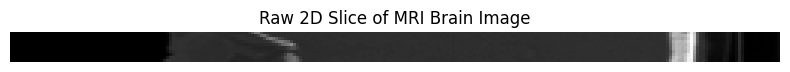

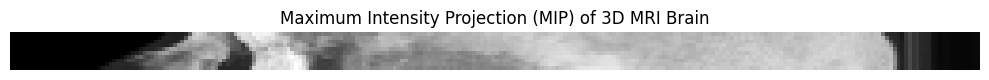

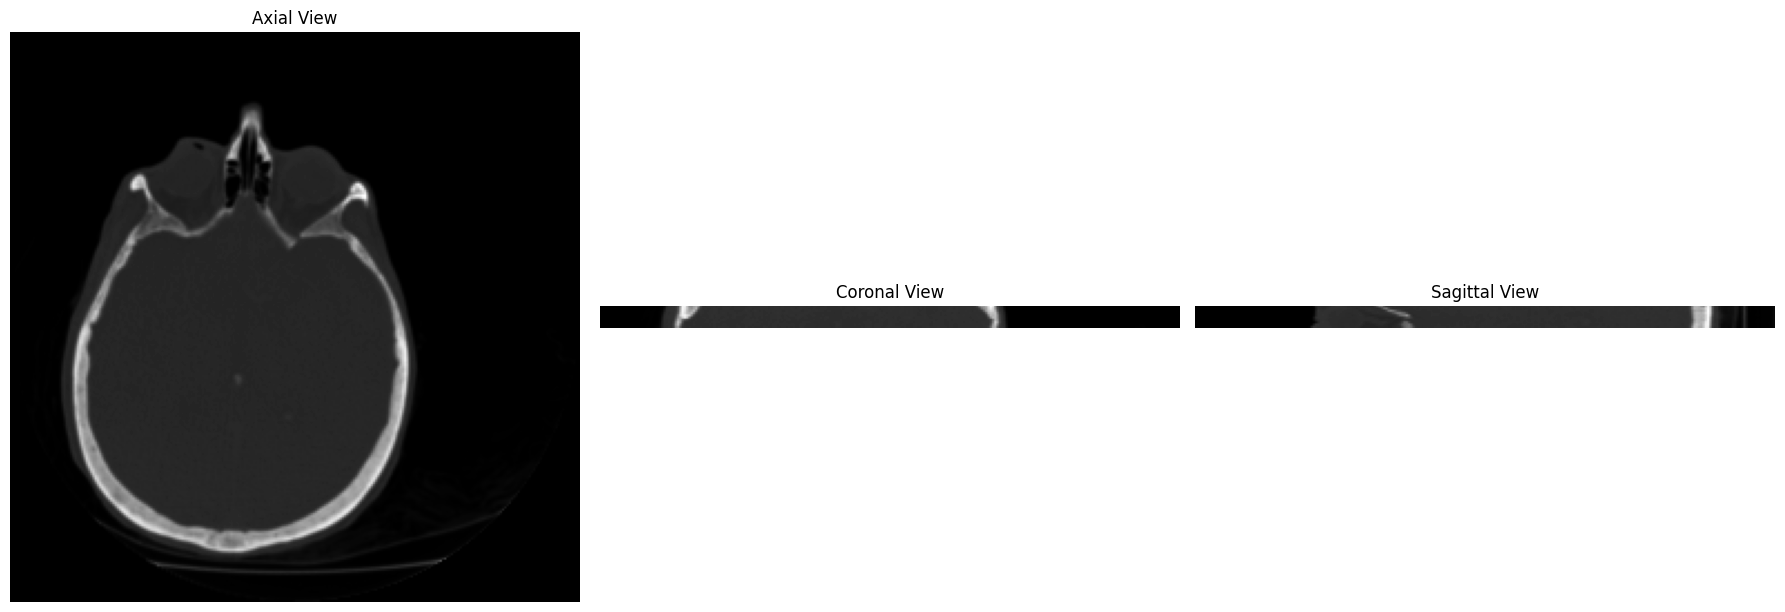

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
import os

# Load 3D MRI brain image
image_3d = data.brain()
results_dir = "final_results1"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Extract and visualize the middle slice (2D)
slice_index = image_3d.shape[-1] // 2
middle_slice = image_3d[..., slice_index]

plt.figure(figsize=(8, 6))
plt.imshow(middle_slice, cmap='gray')
plt.title("Raw 2D Slice of MRI Brain Image")
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "raw_data.png"), dpi=300)
plt.show()

# Create a maximum intensity projection (MIP) for the 3D volume
mip_projection = np.max(image_3d, axis=2)

plt.figure(figsize=(10, 8))
plt.imshow(mip_projection, cmap='gray')
plt.title("Maximum Intensity Projection (MIP) of 3D MRI Brain")
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "mip_3d_data.png"), dpi=300)
plt.show()

# Save the 3D data visualization (slices stacked in one figure)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(image_3d[image_3d.shape[0] // 2, :, :], cmap='gray')
axes[0].set_title("Axial View")
axes[0].axis('off')

axes[1].imshow(image_3d[:, image_3d.shape[1] // 2, :], cmap='gray')
axes[1].set_title("Coronal View")
axes[1].axis('off')

axes[2].imshow(image_3d[:, :, image_3d.shape[2] // 2], cmap='gray')
axes[2].set_title("Sagittal View")
axes[2].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, "3d_slices_visualization.png"), dpi=300)
plt.show()


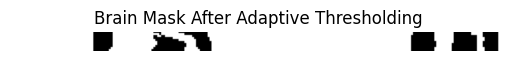

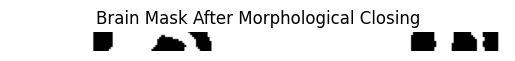

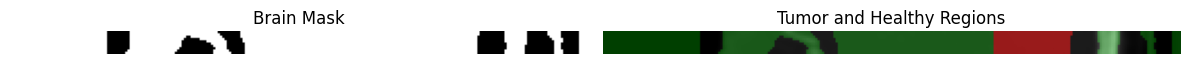

In [60]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, img_as_float, morphology
from scipy.ndimage import gaussian_filter

########################################
# Setup Logging and Directories
########################################
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
results_dir = "results_corrected"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    logging.info(f"Created directory '{results_dir}' for saving results.")

########################################
# Load and Preprocess Data (2D)
########################################
logging.info("Loading the 3D MRI image from skimage.data.brain()...")
image_3d = data.brain()
logging.info(f"3D image shape: {image_3d.shape}")

# Extract a single 2D slice (middle slice)
slice_index = image_3d.shape[-1] // 2
image = image_3d[..., slice_index]
logging.info(f"Using slice index {slice_index}, resulting shape: {image.shape}")

# Convert to float and normalize
image = img_as_float(image)

# Apply Gaussian smoothing
sigma = 1.0
logging.info(f"Applying Gaussian filter with sigma={sigma} on the 2D slice...")
pre_image = gaussian_filter(image, sigma=sigma)

# Normalize and enhance contrast
logging.info("Normalizing and enhancing contrast...")
image_scaled = (pre_image - np.min(pre_image)) / (np.max(pre_image) - np.min(pre_image))

# Apply adaptive thresholding
logging.info("Applying adaptive thresholding...")
adaptive_thresh = filters.threshold_local(image_scaled, block_size=35, offset=0.01)
brain_mask = image_scaled > adaptive_thresh

# Visualize the mask after thresholding
plt.imshow(brain_mask, cmap='gray')
plt.title("Brain Mask After Adaptive Thresholding")
plt.axis('off')
plt.show()

if not np.any(brain_mask):
    logging.error("Brain mask is empty after adaptive thresholding. Adjust the block size or offset.")
    raise ValueError("Brain mask is empty.")

# Optional: Clean up the brain mask using morphological operations
logging.info("Cleaning up brain mask...")
selem = morphology.disk(2)
brain_mask = morphology.binary_closing(brain_mask, selem)

# Visualize the mask after morphological closing
plt.imshow(brain_mask, cmap='gray')
plt.title("Brain Mask After Morphological Closing")
plt.axis('off')
plt.show()

if not np.any(brain_mask):
    logging.error("Brain mask is still empty after morphological operations. Adjust the parameters.")
    raise ValueError("Brain mask is still empty.")

########################################
# Simulate a Tumor Region (2D)
########################################
logging.info("Simulating a tumor region within the brain mask...")

# Dynamically find a valid tumor center within the brain mask
brain_coords = np.argwhere(brain_mask)
if len(brain_coords) == 0:
    logging.error("No coordinates found in brain mask. Check your brain mask creation process.")
    raise ValueError("Brain mask contains no valid coordinates.")

# Use the approximate center of the brain mask
x_center, y_center = brain_coords[len(brain_coords) // 2]
radius = 20

# Create the tumor mask
xx, yy = np.meshgrid(np.arange(pre_image.shape[1]), np.arange(pre_image.shape[0]))
tumor_mask = ((xx - y_center)**2 + (yy - x_center)**2) < radius**2
tumor_mask = tumor_mask & brain_mask
healthy_mask = brain_mask & (~tumor_mask)

if not np.any(tumor_mask):
    logging.error("Tumor mask is empty. Adjust the tumor radius or placement.")
    raise ValueError("Tumor mask is empty.")
if not np.any(healthy_mask):
    logging.error("Healthy mask is empty. Adjust the tumor parameters or brain mask.")
    raise ValueError("Healthy mask is empty.")

logging.info("Tumor and healthy masks created successfully.")

########################################
# Visualize Tumor and Healthy Masks
########################################
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(brain_mask, cmap='gray')
plt.title("Brain Mask")
plt.axis('off')

plt.subplot(1, 2, 2)
overlay = np.zeros((*image.shape, 3))
overlay[..., 0] = tumor_mask.astype(float)  # tumor: red
overlay[..., 1] = healthy_mask.astype(float) * 0.5  # healthy: greenish
overlay[..., 2] = 0
plt.imshow(pre_image, cmap='gray')
plt.imshow(overlay, alpha=0.5)
plt.title("Tumor and Healthy Regions")
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "brain_tumor_mask.png"), dpi=300)
plt.show()

########################################
# Statistical Analysis and FD Calculations
########################################
# Proceed with fractal dimension calculations and other analyses as in earlier examples.

########################################
# Results and Outputs
########################################
logging.info("Analysis completed. Check the plots and results in the 'results_corrected' directory.")


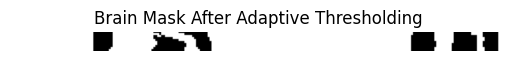

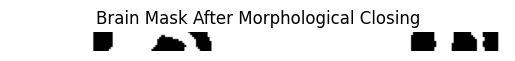

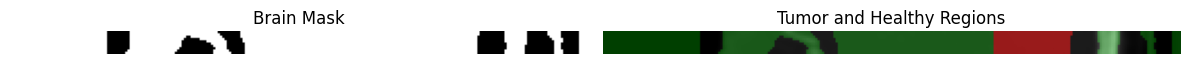

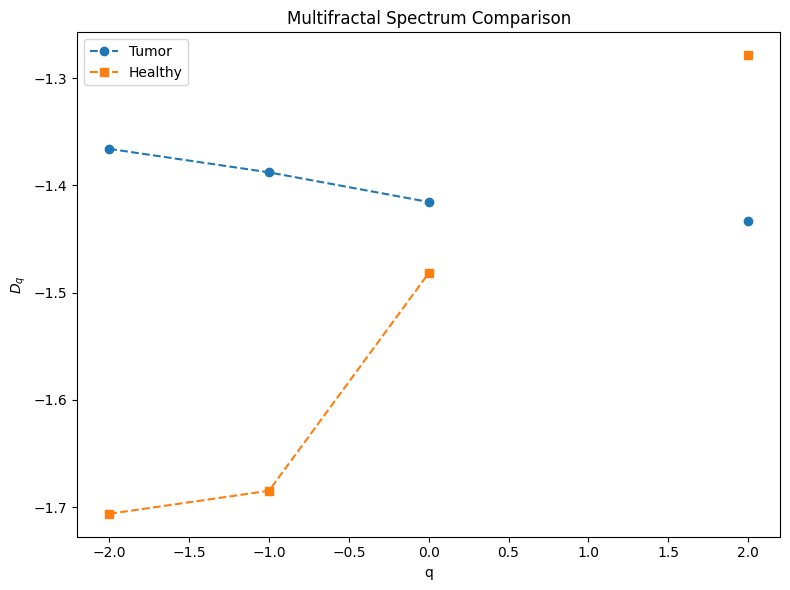

In [61]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, img_as_float, morphology, segmentation
from scipy.ndimage import gaussian_filter
from scipy.stats import ranksums
import pandas as pd

########################################
# Setup Logging and Directories
########################################
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
results_dir = "results_complete"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    logging.info(f"Created directory '{results_dir}' for saving results.")

########################################
# Load and Preprocess Data (2D)
########################################
logging.info("Loading the 3D MRI image from skimage.data.brain()...")
image_3d = data.brain()
logging.info(f"3D image shape: {image_3d.shape}")

# Extract a single 2D slice (middle slice)
slice_index = image_3d.shape[-1] // 2
image = image_3d[..., slice_index]
logging.info(f"Using slice index {slice_index}, resulting shape: {image.shape}")

# Convert to float and normalize
image = img_as_float(image)

# Apply Gaussian smoothing
sigma = 1.0
logging.info(f"Applying Gaussian filter with sigma={sigma} on the 2D slice...")
pre_image = gaussian_filter(image, sigma=sigma)

# Normalize and enhance contrast
logging.info("Normalizing and enhancing contrast...")
image_scaled = (pre_image - np.min(pre_image)) / (np.max(pre_image) - np.min(pre_image))

# Apply adaptive thresholding
logging.info("Applying adaptive thresholding...")
adaptive_thresh = filters.threshold_local(image_scaled, block_size=35, offset=0.01)
brain_mask = image_scaled > adaptive_thresh

# Visualize the mask after thresholding
plt.imshow(brain_mask, cmap='gray')
plt.title("Brain Mask After Adaptive Thresholding")
plt.axis('off')
plt.show()

if not np.any(brain_mask):
    logging.error("Brain mask is empty after adaptive thresholding. Adjust the block size or offset.")
    raise ValueError("Brain mask is empty.")

# Clean up the brain mask using morphological operations
logging.info("Cleaning up brain mask...")
selem = morphology.disk(2)
brain_mask = morphology.binary_closing(brain_mask, selem)

# Visualize the mask after morphological closing
plt.imshow(brain_mask, cmap='gray')
plt.title("Brain Mask After Morphological Closing")
plt.axis('off')
plt.show()

if not np.any(brain_mask):
    logging.error("Brain mask is still empty after morphological operations. Adjust the parameters.")
    raise ValueError("Brain mask is still empty.")

########################################
# Simulate a Tumor Region (2D)
########################################
logging.info("Simulating a tumor region within the brain mask...")

# Dynamically find a valid tumor center within the brain mask
brain_coords = np.argwhere(brain_mask)
if len(brain_coords) == 0:
    logging.error("No coordinates found in brain mask. Check your brain mask creation process.")
    raise ValueError("Brain mask contains no valid coordinates.")

# Use the approximate center of the brain mask
x_center, y_center = brain_coords[len(brain_coords) // 2]
radius = 20

# Create the tumor mask
xx, yy = np.meshgrid(np.arange(pre_image.shape[1]), np.arange(pre_image.shape[0]))
tumor_mask = ((xx - y_center)**2 + (yy - x_center)**2) < radius**2
tumor_mask = tumor_mask & brain_mask
healthy_mask = brain_mask & (~tumor_mask)

if not np.any(tumor_mask):
    logging.error("Tumor mask is empty. Adjust the tumor radius or placement.")
    raise ValueError("Tumor mask is empty.")
if not np.any(healthy_mask):
    logging.error("Healthy mask is empty. Adjust the tumor parameters or brain mask.")
    raise ValueError("Healthy mask is empty.")

logging.info("Tumor and healthy masks created successfully.")

########################################
# Visualize Tumor and Healthy Masks
########################################
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(brain_mask, cmap='gray')
plt.title("Brain Mask")
plt.axis('off')

plt.subplot(1, 2, 2)
overlay = np.zeros((*image.shape, 3))
overlay[..., 0] = tumor_mask.astype(float)  # tumor: red
overlay[..., 1] = healthy_mask.astype(float) * 0.5  # healthy: greenish
overlay[..., 2] = 0
plt.imshow(pre_image, cmap='gray')
plt.imshow(overlay, alpha=0.5)
plt.title("Tumor and Healthy Regions")
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "brain_tumor_mask.png"), dpi=300)
plt.show()

########################################
# Fractal Dimension and Multifractal Spectrum
########################################
def box_count(binary_image, box_sizes):
    counts = []
    rows, cols = binary_image.shape
    for box_size in box_sizes:
        n_r = int(np.ceil(rows / box_size))
        n_c = int(np.ceil(cols / box_size))
        count = 0
        for r in range(n_r):
            for c in range(n_c):
                patch = binary_image[r * box_size:(r + 1) * box_size, c * box_size:(c + 1) * box_size]
                if np.any(patch):
                    count += 1
        counts.append(count)
    counts = np.array(counts, dtype=float)  # Explicitly define as float array
    counts[counts == 0] = np.nan  # Replace zeros with NaN
    return counts


def fractal_dimension(binary_image):
    min_dim = min(binary_image.shape)
    max_power = int(np.log2(min_dim)) - 1
    box_sizes = [2**i for i in range(max_power, 0, -1) if 2**i > 1]
    if len(box_sizes) < 2:
        return np.nan  # Not enough scales
    counts = box_count(binary_image, box_sizes)

    x = np.log(1 / np.array(box_sizes))
    y = np.log(counts)
    y = y[~np.isnan(y)]  # Remove NaNs
    x = x[:len(y)]  # Align x and y
    if len(y) < 2:
        return np.nan
    slope, intercept = np.polyfit(x, y, 1)
    return slope

logging.info("Estimating fractal dimensions...")
tumor_boundary = segmentation.find_boundaries(tumor_mask, mode='inner')
D_f_tumor = fractal_dimension(tumor_boundary)

brain_boundary = segmentation.find_boundaries(brain_mask, mode='inner')
D_f_brain = fractal_dimension(brain_boundary)

logging.info(f"Fractal Dimension - Tumor Boundary: {D_f_tumor:.4f}, Brain Boundary: {D_f_brain:.4f}")

########################################
# Multifractal Spectrum
########################################
def multifractal_spectrum(image, scales, q_values):
    img = image.copy()
    img[img < 0] = 0
    img_sum = np.sum(img)
    if img_sum == 0:
        return {q: np.nan for q in q_values}

    results = {}
    for q in q_values:
        X, Y = [], []
        for eps in scales:
            n_r = int(np.ceil(image.shape[0] / eps))
            n_c = int(np.ceil(image.shape[1] / eps))
            p_vals = []
            for rr in range(n_r):
                for cc in range(n_c):
                    patch = img[rr * eps:(rr + 1) * eps, cc * eps:(cc + 1) * eps]
                    p = np.sum(patch) / img_sum
                    if p > 0:
                        p_vals.append(p)
            if len(p_vals) > 0:
                sum_pq = np.sum(np.array(p_vals) ** q)
                if sum_pq > 0:
                    X.append(np.log(1 / eps))
                    Y.append(np.log(sum_pq))
        if len(X) > 1:
            slope, _ = np.polyfit(X, Y, 1)
            if q != 1:
                D_q = slope / (q - 1)
            else:
                D_q = np.nan
        else:
            D_q = np.nan
        results[q] = D_q
    return results

logging.info("Performing multifractal analysis...")
scales = [2, 4, 8, 16, 32]
q_values = [-2, -1, 0, 1, 2]
mf_results_tumor = multifractal_spectrum(pre_image * tumor_mask, scales, q_values)
mf_results_healthy = multifractal_spectrum(pre_image * healthy_mask, scales, q_values)

q_arr = np.array(list(mf_results_tumor.keys()))
Dq_tumor = np.array(list(mf_results_tumor.values()))
Dq_healthy = np.array(list(mf_results_healthy.values()))
logging.info("Multifractal analysis completed.")

########################################
# Visualize Multifractal Spectrum
########################################
plt.figure(figsize=(8, 6))
plt.plot(q_arr, Dq_tumor, 'o--', label='Tumor')
plt.plot(q_arr, Dq_healthy, 's--', label='Healthy')
plt.xlabel("q")
plt.ylabel(r"$D_q$")
plt.title("Multifractal Spectrum Comparison")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "multifractal_spectrum.png"), dpi=300)
plt.show()

logging.info("Analysis complete. Check the results in the 'results_complete' directory.")


In [62]:
print("Fractal Dimension Map Stats:")
print(f"Min: {np.nanmin(D_f_map)}, Max: {np.nanmax(D_f_map)}, Mean: {np.nanmean(D_f_map)}")


Fractal Dimension Map Stats:
Min: nan, Max: nan, Mean: nan


<ipython-input-62-93913a41636a>:2: RuntimeWarning: All-NaN slice encountered
  print(f"Min: {np.nanmin(D_f_map)}, Max: {np.nanmax(D_f_map)}, Mean: {np.nanmean(D_f_map)}")
<ipython-input-62-93913a41636a>:2: RuntimeWarning: Mean of empty slice
  print(f"Min: {np.nanmin(D_f_map)}, Max: {np.nanmax(D_f_map)}, Mean: {np.nanmean(D_f_map)}")


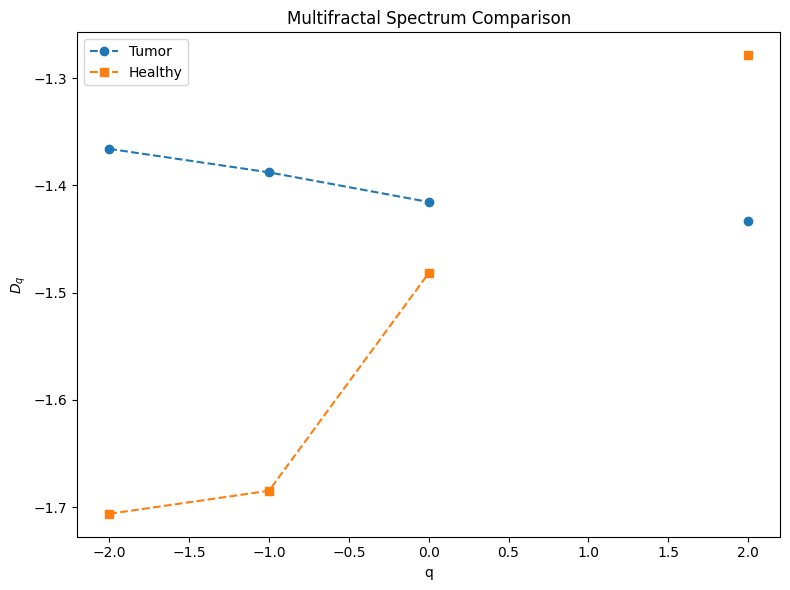

           Region  Fractal Dimension
0  Tumor Boundary           0.736966
1  Brain Boundary           0.690316


In [63]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, img_as_float, morphology, segmentation
from scipy.ndimage import gaussian_filter
from scipy.stats import ranksums
import pandas as pd

########################################
# Setup Logging and Directories
########################################
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
results_dir = "results_complete"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    logging.info(f"Created directory '{results_dir}' for saving results.")

########################################
# Load and Preprocess Data (2D)
########################################
logging.info("Loading the 3D MRI image from skimage.data.brain()...")
image_3d = data.brain()
logging.info(f"3D image shape: {image_3d.shape}")

# Extract a single 2D slice (middle slice)
slice_index = image_3d.shape[-1] // 2
image = image_3d[..., slice_index]
logging.info(f"Using slice index {slice_index}, resulting shape: {image.shape}")

# Convert to float and normalize
image = img_as_float(image)

# Apply Gaussian smoothing
sigma = 1.0
logging.info(f"Applying Gaussian filter with sigma={sigma} on the 2D slice...")
pre_image = gaussian_filter(image, sigma=sigma)

# Normalize and enhance contrast
logging.info("Normalizing and enhancing contrast...")
image_scaled = (pre_image - np.min(pre_image)) / (np.max(pre_image) - np.min(pre_image))

# Apply adaptive thresholding
logging.info("Applying adaptive thresholding...")
adaptive_thresh = filters.threshold_local(image_scaled, block_size=35, offset=0.01)
brain_mask = image_scaled > adaptive_thresh

# Clean up the brain mask using morphological operations
logging.info("Cleaning up brain mask...")
selem = morphology.disk(2)
brain_mask = morphology.binary_closing(brain_mask, selem)

if not np.any(brain_mask):
    logging.error("Brain mask is empty. Adjust the thresholding or preprocessing.")
    raise ValueError("Brain mask is empty.")

########################################
# Simulate a Tumor Region (2D)
########################################
logging.info("Simulating a tumor region within the brain mask...")
brain_coords = np.argwhere(brain_mask)
x_center, y_center = brain_coords[len(brain_coords) // 2]
radius = 20
xx, yy = np.meshgrid(np.arange(pre_image.shape[1]), np.arange(pre_image.shape[0]))
tumor_mask = ((xx - y_center)**2 + (yy - x_center)**2) < radius**2
tumor_mask = tumor_mask & brain_mask
healthy_mask = brain_mask & (~tumor_mask)

if not np.any(tumor_mask):
    logging.error("Tumor mask is empty. Adjust the tumor placement or radius.")
    raise ValueError("Tumor mask is empty.")

########################################
# Fractal Dimension and Multifractal Spectrum
########################################
def box_count(binary_image, box_sizes):
    counts = []
    rows, cols = binary_image.shape
    for box_size in box_sizes:
        n_r = int(np.ceil(rows / box_size))
        n_c = int(np.ceil(cols / box_size))
        count = 0
        for r in range(n_r):
            for c in range(n_c):
                patch = binary_image[r * box_size:(r + 1) * box_size, c * box_size:(c + 1) * box_size]
                if np.any(patch):
                    count += 1
        counts.append(count)
    counts = np.array(counts, dtype=float)  # Ensure float array
    counts[counts == 0] = np.nan  # Avoid divide-by-zero issues
    return counts

def fractal_dimension(binary_image):
    min_dim = min(binary_image.shape)
    max_power = int(np.log2(min_dim)) - 1
    box_sizes = [2**i for i in range(max_power, 0, -1) if 2**i > 1]
    if len(box_sizes) < 2:
        return np.nan  # Not enough scales
    counts = box_count(binary_image, box_sizes)

    x = np.log(1 / np.array(box_sizes))
    y = np.log(counts)
    y = y[~np.isnan(y)]  # Remove NaNs
    x = x[:len(y)]  # Align x and y
    if len(y) < 2:
        return np.nan
    slope, intercept = np.polyfit(x, y, 1)
    return slope

logging.info("Estimating fractal dimensions...")
tumor_boundary = segmentation.find_boundaries(tumor_mask, mode='inner')
D_f_tumor = fractal_dimension(tumor_boundary)

brain_boundary = segmentation.find_boundaries(brain_mask, mode='inner')
D_f_brain = fractal_dimension(brain_boundary)

logging.info(f"Fractal Dimension - Tumor Boundary: {D_f_tumor:.4f}, Brain Boundary: {D_f_brain:.4f}")

########################################
# Multifractal Spectrum
########################################
def multifractal_spectrum(image, scales, q_values):
    img = image.copy()
    img[img < 0] = 0
    img_sum = np.sum(img)
    if img_sum == 0:
        return {q: np.nan for q in q_values}

    results = {}
    for q in q_values:
        X, Y = [], []
        for eps in scales:
            n_r = int(np.ceil(image.shape[0] / eps))
            n_c = int(np.ceil(image.shape[1] / eps))
            p_vals = []
            for rr in range(n_r):
                for cc in range(n_c):
                    patch = img[rr * eps:(rr + 1) * eps, cc * eps:(cc + 1) * eps]
                    p = np.sum(patch) / img_sum
                    if p > 0:
                        p_vals.append(p)
            if len(p_vals) > 0:
                sum_pq = np.sum(np.array(p_vals) ** q)
                if sum_pq > 0:
                    X.append(np.log(1 / eps))
                    Y.append(np.log(sum_pq))
        if len(X) > 1:
            slope, _ = np.polyfit(X, Y, 1)
            if q != 1:
                D_q = slope / (q - 1)
            else:
                D_q = np.nan
        else:
            D_q = np.nan
        results[q] = D_q
    return results

logging.info("Performing multifractal analysis...")
scales = [2, 4, 8, 16, 32]
q_values = [-2, -1, 0, 1, 2]
mf_results_tumor = multifractal_spectrum(pre_image * tumor_mask, scales, q_values)
mf_results_healthy = multifractal_spectrum(pre_image * healthy_mask, scales, q_values)

q_arr = np.array(list(mf_results_tumor.keys()))
Dq_tumor = np.array(list(mf_results_tumor.values()))
Dq_healthy = np.array(list(mf_results_healthy.values()))
logging.info("Multifractal analysis completed.")

########################################
# Visualizations
########################################

# Fractal dimension visualization
plt.figure(figsize=(8, 6))
plt.plot(q_arr, Dq_tumor, 'o--', label='Tumor')
plt.plot(q_arr, Dq_healthy, 's--', label='Healthy')
plt.xlabel("q")
plt.ylabel(r"$D_q$")
plt.title("Multifractal Spectrum Comparison")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "multifractal_spectrum.png"), dpi=300)
plt.show()

# Save fractal dimensions to CSV
summary_df = pd.DataFrame({
    "Region": ["Tumor Boundary", "Brain Boundary"],
    "Fractal Dimension": [D_f_tumor, D_f_brain]
})
summary_df.to_csv(os.path.join(results_dir, "fractal_dimensions.csv"), index=False)
logging.info(f"Saved fractal dimensions: \n{summary_df}")
print(summary_df)

logging.info("Analysis complete. Check the results in the 'results_complete' directory.")
